# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

При анализе исходных данных были выявлены следующие моменты:
1.	first_day_exposition имеет тип object, а по-хорошему должен быть тип datetime
2.	ceiling_height имеет пропуски в данных
3.	floors_total имеет тип float64, учитывая, что количество этажей не может быть дробным логичнее применить тип int, также наблюдаются пропуски в данных
4.	living_area имеет пропуски в данных
5.	is_apartment имеет тип object, а по-хорошему должен быть тип bool. Имеются пропуски в данных
6.	kitchen_area имеет пропуски в данных
7.	balcony имеет пропуски в данных, а учитывая, что количество балконов не может быть дробным логичнее применить тип int
8.	locality_name имеет пропуски в данных
9.	airports_nearest имеет пропуски в данных
10.	cityCenters_nearest имеет пропуски в данных
11.	parks_around3000 имеет пропуски в данных, а также количество парков не может быть дробным, необходимо перевести к типу int
12.	parks_nearest имеет пропуски в данных
13.	ponds_around3000 имеет пропуски в данных, а также количество водоемов не может быть дробным, необходимо перевести к типу int
14.	ponds_nearest имеет пропуски в данных
15.	days_exposition имеет пропуски в данных, а также логичнее привести к целочисленному типу

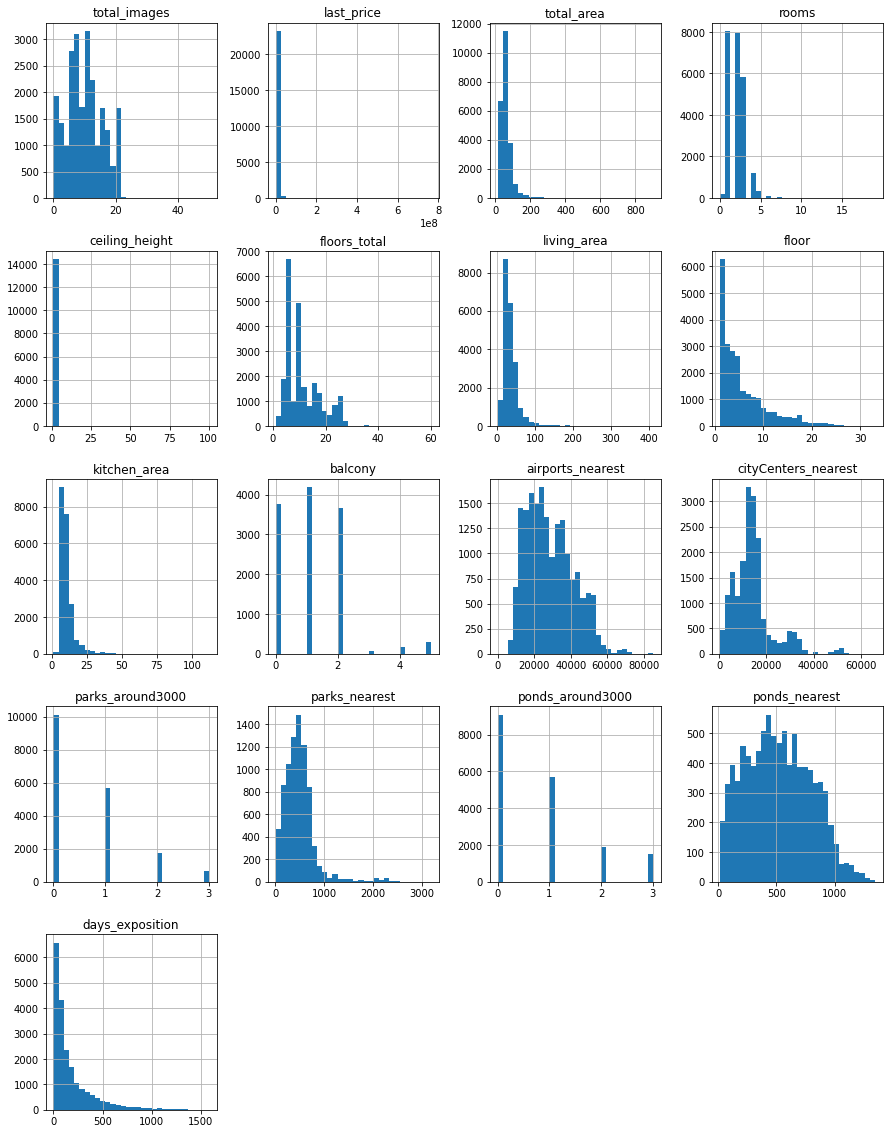

In [5]:
data.hist(bins=30,figsize=(15,20))
plt.show()

In [6]:
#Запишем количество записей в исходном датафреме
old_shape_data = data.shape[0]

### Предобработка данных

#### Проверим данные на наличие явных дубликатов

In [7]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют. Следующим шагом заполним пропуски в данных по стлбцам, где это возможно, приведем типы данных к необходимым и обработаем аномальные значения.

#### Заполнение пропусков и удаление аномальных значений

##### Обработка столбцов parks_around3000  и ponds_around3000

In [8]:
print('Количество пропусков в столбце parks_around3000 составялет', data['parks_around3000'].isna().sum())
print('Количество пропусков в столбце ponds_around3000 составялет', data['ponds_around3000'].isna().sum())

Количество пропусков в столбце parks_around3000 составялет 5518
Количество пропусков в столбце ponds_around3000 составялет 5518


Одинаковое количество пропусков. Природа пропусков не ясна и восстановить пропуски будет весьма затруднительно, а ценности в этих данных нет. Оставим пропуски без обработки.

In [9]:
#Изменим тип данных на целочисленный
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')

Пропуски в данных могли быть допущены по одной из следующих причин:
- продавец не указывал эти данные, т.к. эти показатели не обязательны к заполнению и не являются ключевыми при продаже объектов недвижимости 
- показатели считаются системой автоматически и по какой-то причине произошел сбой (на что указывает одинаковое количество пропусков в обоих столбцах)

Тип данных приведен к целочисленному исходя из того, что количество парков или водоемов не может быть дробным. Учитывая, что столбцы parks_around3000 и ponds_around3000 не пригодятся для анализа, а корректно восстановить пропуски в данных будет весьма затруднительно оставим пропуски без изменений.

##### Обработка столбца ponds_nearest 

In [10]:
print('Количество пропусков в столбце ponds_nearest составялет', data['ponds_nearest'].isna().sum())

Количество пропусков в столбце ponds_nearest составялет 14589


В столбце ponds_nearest достаточно большое количество пропущенных значений (около 60%), а учитывая, что эти данные для анализа не несут ценности оставим пропуски без заполнений.
Пропуски в данных могли быть допущены по причине того, что продавец не указывал эти данные, т.к. этот показатель вероятнее всего не обязателен к заполнению, а также не является ключевыми при продаже объектов недвижимости.

##### Обработка столбца first_day_exposition

In [11]:
# Приводим к типу datetime даты дату публикации объявлений
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

##### Обработка столбца days_exposition

In [12]:
print('Количество пропусков в столбце days_exposition составялет', data['days_exposition'].isna().sum())

Количество пропусков в столбце days_exposition составялет 3181


#Приведем к целочисленному типу
data['days_exposition'] = data['days_exposition'].dropna()data_pivotcolumns.astype('Int64')

Показатель весьма ценен, но заменять пропуски медианным, средним или нулевым значением будет не совсем корректно, так как природа пропусков совершенна не ясна. Восстановить эти пропуски не получится, поэтому пропуски остались не заполненными.

Вполне возможно, что пропуски могут присутствовать, например, по причине того, что неизвестно когда было закрыто объявление о продаже, т.е. по факту сделка была совершена, но не была закрыта в сервисе.

Как-правило количество дней - целое число и поэтому тип данных приведен к целочисленному.

##### Обработка столбца living_area и kitchen_area

In [13]:
print('Количество пропусков в столбце living_area:', data['living_area'].isnull().sum())
print('Количество пропусков в столбце kitchen_area:', data['kitchen_area'].isnull().sum())

Количество пропусков в столбце living_area: 1903
Количество пропусков в столбце kitchen_area: 2278


Проверим данные на наличие не корректных значений, в которых жилая площадь равна площади кухни и при этом квартира не является студией.

In [14]:
data.query('kitchen_area == living_area and studio == False').shape[0]

40

Удалим такие строки.

In [15]:
data.drop(data.query('kitchen_area == living_area and studio == False').index, inplace=True)

Выполним аналогичную проверку для жилой и общей площади.

In [16]:
data.query('total_area == living_area and studio == False').shape[0]

2

Удалим такие аномалии.

In [17]:
data.drop(data.query('total_area == living_area and studio == False').index, inplace=True)

Проерка на наличие значений для которых суммарная жилая и кухонная площадь больщей общей.

In [18]:
data.query('total_area < kitchen_area + living_area').shape[0]

59

Как работать с такими с такими выбросами в данных не свосем понятно, поэтому удалим эти строки.

In [19]:
data.drop(data.query('total_area < kitchen_area + living_area').index, inplace=True)

Проверим данные на наличие срок для которых площадь кухни больше жилой, т.к. как-правило площадь кухни не может превышать жилую площадь.

In [20]:
data.query('kitchen_area > living_area').shape[0]

354

Вероятно площадь кухни и жилая площадь при заполнении объявлений были перепутаны. Выполним преобразование - поменяем местами площадь кухни и жилую.

In [21]:
bad_area = data.loc[data['kitchen_area'] > data['living_area'],['kitchen_area','living_area']]

data.loc[bad_area.index,'kitchen_area'] = data.loc[bad_area.index, 'living_area']
data.loc[bad_area.index,'living_area'] = data.loc[bad_area.index, 'kitchen_area']

Пропуски в данных по жилой и кухонной площади предлагается заполнять исходя из отношения жилой/ кухонной площади к общей площади. Проведем категоризацию данных по общей площади, но предвариательно посмотрим диаграмму размаха, чтобы понять как лучше проводить группировку.

(0.0, 500.0)

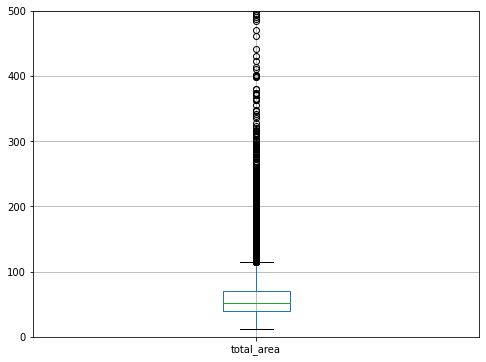

In [22]:
data.plot(y='total_area', kind ='box', figsize=(8,6), grid = True)
plt.ylim(0,500)

Итак, квартиры с площадью до 100 кв.м. будем делить в группы по 10 кв.м., от 100 до 200 кв.м. по 20 кв.м., от 200 до 300 по 50 кв.м. оставшиеся значения будет помещены в группу свыше 300 кв.м. (как наиболее редкие).

In [23]:
#Категоризируем данные по общей плоащди
def get_total_cat (value):
    if value <= 10:
        return 'Общая площадь до 10 кв м.'
    elif value <= 20:
        return 'Общая площадь до 20 кв м.'
    elif value <= 30:
        return 'Общая площадь до 30 кв м.'
    elif value <= 40:
        return 'Общая площадь до 40 кв м.'
    elif value <= 50:
        return 'Общая площадь до 50 кв м.'
    elif value <= 60:
        return 'Общая площадь до 60 кв м.'
    elif value <= 70:
        return 'Общая площадь до 70 кв м.'
    elif value <= 80:
        return 'Общая площадь до 80 кв м.'
    elif value <= 90:
        return 'Общая площадь до 90 кв м.'
    elif value <= 100:
        return 'Общая площадь до 100 кв м.'
    elif value <= 120:
        return 'Общая площадь до 120 кв м.'
    elif value <= 140:
        return 'Общая площадь до 140 кв м.'
    elif value <= 160:
        return 'Общая площадь до 160 кв м.'
    elif value <= 180:
        return 'Общая площадь до 180 кв м.'
    elif value <= 200:
        return 'Общая площадь до 200 кв м.'
    elif value <= 250:
        return 'Общая площадь до 250 кв м.'
    elif value <= 300:
        return 'Общая площадь до 300 кв м.'
    else:
        return 'Общая площадь свыше 300 кв м.'

data['category_total_area'] = data['total_area'].apply(get_total_cat)

In [24]:
#Создадим сводную таблицу cо средним значением жилой, общей и кухонной площадей
data_area = data.pivot_table(
    index='category_total_area',
    values =['living_area', 'kitchen_area', 'total_area'],
    aggfunc = 'mean')
#Дополним таблицу отношением жилой и кухонной площадей к общей
data_area['ratio_living_area'] = (data_area['living_area'] / data_area['total_area']).round(2)
data_area['ratio_kitchen_area'] = (data_area['kitchen_area'] / data_area['total_area']).round(2)
#Лишние столбцы удалим
data_area.drop(columns=['kitchen_area', 'living_area', 'total_area'], inplace=True)

In [25]:
data_area.head()

,ratio_living_area,ratio_kitchen_area
category_total_area,,
Общая площадь до 100 кв м.,0.58,0.16
Общая площадь до 120 кв м.,0.58,0.16
Общая площадь до 140 кв м.,0.58,0.15
Общая площадь до 160 кв м.,0.59,0.15
Общая площадь до 180 кв м.,0.58,0.13


In [26]:
#Заполним пропуски в данных исходя из группы по общей площади квартир следующим образом:
#значение общей площади по каждой строке (для которой есть пропуск в жилой или кухонной плоащдей)
#умножается на к-т отношения жилой/кухонной плоащди к общей из сводной таблицы data_area

for cat_total_area in data_area.index:
    #Заполнение пропусков в столбце living_area
    data.loc[(data['living_area'].isna()) & (data['category_total_area'] == cat_total_area), 'living_area'] = \
    data.loc[(data['living_area'].isna()) & (data['category_total_area'] == cat_total_area),'total_area'] *  \
    data_area.loc[cat_total_area, 'ratio_living_area']
    
    #Заполнение пропусков в столбце kitchen_area
    data.loc[(data['kitchen_area'].isna()) & (data['category_total_area'] == cat_total_area), 'kitchen_area'] = \
    data.loc[(data['kitchen_area'].isna()) & (data['category_total_area'] == cat_total_area),'total_area'] *  \
    data_area.loc[cat_total_area, 'ratio_kitchen_area']

In [27]:
print('Количество пропусков в столбце  living_area после обработки:', data['living_area'].isnull().sum())
print('Количество пропусков в столбце kitchen_area после обработки:', data['kitchen_area'].isnull().sum())

Количество пропусков в столбце  living_area после обработки: 0
Количество пропусков в столбце kitchen_area после обработки: 0


Выполним проверку на наличие строк в которых сумма жилой и кухонной площадей больше общей площади.

In [28]:
data.query('total_area < kitchen_area + living_area').shape[0]

70

In [29]:
#Удалим такие строки
data.drop(data.query('total_area < kitchen_area + living_area').index, inplace=True)

Выполним проверку на наличие строк в которых общая площадь совпадает с площадью кухни.

In [30]:
data.query('total_area == kitchen_area').shape[0]

0

Аналогичная проверка для жилой площади.

In [31]:
data.query('total_area == living_area').shape[0]

0

Выполним проверку строк в которых площадь кухни больше жилой площади.

In [32]:
data.query('kitchen_area > living_area').shape[0]

2

In [33]:
#Удалим такие строки
data.drop(data.query('kitchen_area > living_area').index, inplace=True)

Пропуски в данных могли образоваться по причине того, что параметры жилой и кухонных площадей не являются обязательными к заполнению, а чтобы найти эти данные необходимо изучить экспликации/ тех паспорта на что, возможно, у продавцов нет времени.

В данных встречались и явные ошибки, такие как: площадь кухни совпадала с жилой площадью, жилая площадь совпадала с общей и площадь кухни с учетом жилой площади больше общей площади - как работать с такими ошибками не совсем понятно, поэтому было принято решение об исключении таких данных из анализа. Также встретились в данных в которых площадь кухни больше жилой площади - такой сценарий маловероятен, возможно при заполнении объявлений площадь кухни и жилая были перепутаны. Исходя из такого допущения такие строки были преобразованы - площадь кухни и жилая площадь поменяны местами.

Пропуски в данных были заполнены были заполнены из отношения жилой/кухонной площади к общей площади в зависимости метража квартир.

##### Обработка столбца balcony

In [34]:
print('Количество пропусков в столбце balcony составялет', data['balcony'].isna().sum())

Количество пропусков в столбце balcony составялет 11451


In [35]:
data['balcony'] = data['balcony'].fillna(0).astype('int')

In [36]:
print('Количество пропусков в столбце balcony после обработки составялет', data['balcony'].isna().sum())

Количество пропусков в столбце balcony после обработки составялет 0


Вероятно, что при заполнении данных некоторые продавцы не указывали количество балконов по той причине, что их в квартире нет. Исходя из этого допущения пропущенные значения в исходных данных были заменены на 0 (отсутствие балконов).

Учитывая, что количество балконов не может быть дробным тип данных был изменен на целочисленный.

Предлагается обсудить с разработчиками и бизнес-аналитиками возможность установления параметра "количество балконов" как обязательное, чтобы в дальнейшем избежать пропусков в данных.

##### Обработка столбца locality_name

In [37]:
print('Количество пропусков в столбце locality_name составялет', data['locality_name'].isna().sum())

Количество пропусков в столбце locality_name составялет 49


Выполним проверку на количество строк в которых отсутствует пропуск в столбце locality_name и cityCenters_nearest 

In [38]:
print('Количество одновременных пропусков в столбце locality_name и cityCenters_nearest составляет', 
      data.query('locality_name.isna() and cityCenters_nearest.isna()').shape[0])

Количество одновременных пропусков в столбце locality_name и cityCenters_nearest составляет 8


Пропуски предлагается заполнять исходя из удаленности от центра СПБ. Такие строки удалим из выборки, т.к. без понимания расстояния до центра СПБ мы не сможем восстановить наименование населенного пункта.

In [39]:
data.drop(data.query('locality_name.isna() and cityCenters_nearest.isna()').index, inplace=True)

По оставшимся пропускам попробуем восстановить данные в зависимости от удаленности от центра СПБ

In [40]:
#Посмотрим уникальные значение по столбцу cityCenters_nearest для строк по котоырм есть пропуски 
data.query('locality_name.isna()')['cityCenters_nearest'].unique()

array([ 4258., 17369.,  8127.,  3902.,  3039.,  5382.,  9538., 16788.,
        8582.,  4627., 12332.,  4065., 31813.,  3801.,  4474.,  4069.,
        4383., 23659.,  9633.,  9497.,  8619.,  1322., 10976.,  8943.,
        8429.,  3312.,  4604., 31897., 41294.,  4805.,  1780.])

Расстояние до центра СПБ по большинству пропусков до 16 км, что примерно соответствует границам СПБ. 
Вызвоим describe для столбца cityCenters_nearest по СПБ

In [41]:
describe_SPB_oncityCenters_nearest = data.loc[data['locality_name'] == "Санкт-Петербург",'cityCenters_nearest'].describe()
describe_SPB_oncityCenters_nearest

count    15545.000000
mean     11604.339016
std       4838.977837
min        181.000000
25%       8340.000000
50%      12243.000000
75%      14945.000000
max      29493.000000
Name: cityCenters_nearest, dtype: float64

Удивительно, что максимальное расстояние 29.5 км - у меня были предположения, что границы СПБ в пределах 15 км, что соответствует 3 квартилю, но все возможно.

Посмотрим сколько значений по которым расстояние до центра СПБ выходит за границы 29.5 км.

In [42]:
data.query('locality_name.isna() and cityCenters_nearest > @describe_SPB_oncityCenters_nearest[7]')['cityCenters_nearest'].value_counts()

31813.0    1
41294.0    1
31897.0    1
Name: cityCenters_nearest, dtype: int64

Таких строк крайне мало. Удалим их из выборки.

In [43]:
data.drop(data.query('locality_name.isna() and cityCenters_nearest > @describe_SPB_oncityCenters_nearest[7]').index, inplace=True)

В целом будем заполянть пропуски исходя из следующих допущений - если в данных пропуск, то продавец не указал населенный пункт, т.к. по умолчанию предполагал, что объект находится в СПБ.

In [44]:
data.loc[(data['locality_name'].isna()) & 
         (data['cityCenters_nearest'] <= describe_SPB_oncityCenters_nearest[7]),'locality_name'] = 'Санкт-Петербург'

In [45]:
print('Количество пропусков в столбце locality_name после обработки составялет', data['locality_name'].isna().sum())

Количество пропусков в столбце locality_name после обработки составялет 0


Пропусков нет, перейдем к обработке неявных дубликатов.

In [46]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

В данных достаточно много неявных дубликатов, проверять все руками достаточно трудоемко и есть вероятность не учесть все дубликаты в полном объеме. Встречаются схожие названия у деревень и поселков/ сел, выборочно проверены отдельные "дубликаты" деревня/поселок, деревня/село на карте. В целом такие объекты граничат друг с другом и исходя из этого можем объединить их под одним наименованием. 

Автоматизируем процесс.

In [47]:
#Функция получения "короткого" наименованяи населенного пункта
def make_short_name(locality_name):
    #Разделяем исходные данные
    split_locality_name = locality_name.split()
    new_locality_name = []
    
    for word in split_locality_name:
        if word[0].isupper(): #Условие проверки - если 1-ый символ с заглавной буквы
            new_locality_name.append(word) 
    
    new_locality_name = ' '.join(word for word in new_locality_name)
    
    return new_locality_name

data['locality_name'] = data['locality_name'].apply(make_short_name)

In [48]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [49]:
print('Количество пропусков в столбце locality_name после обработки составялет', data['locality_name'].isna().sum())

Количество пропусков в столбце locality_name после обработки составялет 0


Пропуски могли образоваться по причине того, что продавец по умолчанию предполагал, что квартира продается в пределах города Санкт-Петербург и поэтому не счел нужным заполнять данные параметр, однако, также возможно, что продавец просто-напросто забыл заполнить этот параметр.

Пропуски в данных заполнялись в следующей логике:
- если расстояние до центра города не указано, то такие данные удалялись, т.к. при отсутствии понимания расстояния восстановить пропуски не возможно;
- пропуски в оставшихся данных были заполнены городом Санкт-Петербург (исходя из предположения выше), если их расстояние до центра города меньше, чем максимальное расстояние до центра Санкт-Петербурга (29.5 км), оставшиеся пропуски (3 шт.) были исключены из выборки.

В данных было достаточно большое количество неявных дубликатов, например "поселок/ посёлок" или "поселок городского типа/ городской поселок" и т.д., также встречались схожие названия у деревень и поселков/ сел, выборочно проверены отдельные "дубликаты" деревня/поселок, деревня/село на карте. В целом такие объекты граничат друг с другом и исходя было принято решение объединить их под одним наименованием.

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Супер! Здесь всё верно)
</div>

##### Обработка столбца floors_total

In [50]:
print('Количество пропусков в столбце floors_total:', data['floors_total'].isnull().sum())

Количество пропусков в столбце floors_total: 85


Учитывая, что мы не знаем природу пропусков заполним пропуски исходя из следующего допщения - если в объявлении отсутствует этажность дома и при этом указан этаж, то этажность дома соответствует этажу в объявлении

In [51]:
data.loc[data['floors_total'].isna(),'floors_total'] = data.loc[data['floors_total'].isna(),'floor']
data['floors_total'] = data['floors_total'].astype('int')

In [52]:
print('Количество пропусков в столбце floors_total после обработки составялет', data['floors_total'].isnull().sum())

Количество пропусков в столбце floors_total после обработки составялет 0


Пропуски в данных могли образоваться по причине того, что параметр является не обязательным к заполнению и, если продавец не указал этажность дома, то предполагал, что указанный в объявлении этаж является последним. Исходя из этого предположения пропуски в данных были заполнены из столбца с номером этажа в объявлении.

Учитывая, что этажность дома не может быть дробным - тип данных изменен на целочисленный.

##### Обработка столбца ceiling_height

Перед обработкой и заполнением пропусков проверим на наличие ошибок в данных. Построим анализ на следующих допущениях:
- высота потолков не может быть меньше 2.4 метров
- высота потолков в двухярусных квартирах или частных домах как правило не превышает 10 метров

Все, что не удовлетворяет эти критериям удалим из выборки.

In [53]:
print('количество строк с высотой потолков более 10 м. равно', len(data.query('ceiling_height > 10')))
#Скорректируем значения для объявлений с высотой потолков более 10 м.
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] /= 10
print('количество строк с высотой потолков более 10 м. после обработки равно', len(data.query('ceiling_height > 10')))

количество строк с высотой потолков более 10 м. равно 23
количество строк с высотой потолков более 10 м. после обработки равно 0


In [54]:
print('количество строк с высотой потолков менее 2.4 м. равно', len(data.query('ceiling_height < 2.4')))
#Исключим из дата фрейма строки с высотой потолков менее 2.4 м., но при этом оставим строки с пропущенными значениями
#data = data.query('ceiling_height >= 2.4 or ceiling_height.isna()')
data.drop(data.query('ceiling_height < 2.4 ').index, inplace=True)
print('количество строк с высотой потолков менее 2.4 м. после обработки равно', len(data.query('ceiling_height < 2.4')))

количество строк с высотой потолков менее 2.4 м. равно 25
количество строк с высотой потолков менее 2.4 м. после обработки равно 0


In [55]:
print('Количество пропусков в столбце ceiling_height составялет', data['ceiling_height'].isna().sum())

Количество пропусков в столбце ceiling_height составялет 9110


In [56]:
#Создадим сгрупированную таблицу с медианной высотой потлоков в разрезе этажностей и этажей
pivot_ceiling_height_on_floor = data.pivot_table(
    index=['floors_total', 'floor'],
    values='ceiling_height', 
    aggfunc ='median')

pivot_ceiling_height_on_floor.head()

ceiling_height
floors_total floor                
1            1                2.90
2            1                2.70
             2                2.72
3            1                2.75
             2                2.80

Заполним пропущенные значения по высоте потолков медианным значением в зависимости от этажности дома и этажа.

In [57]:
for floors_total, floor in pivot_ceiling_height_on_floor.index: #['floor', 'locality_name']):
    data.loc[(data['ceiling_height'].isna()) & (data['floors_total'] == floors_total) & (data['floor'] == floor), 'ceiling_height'] = \
    pivot_ceiling_height_on_floor.loc[(floors_total, floor), 'ceiling_height']

In [58]:
print('Количество пропусков в столбце ceiling_height после обработки составялет', data['ceiling_height'].isna().sum())

Количество пропусков в столбце ceiling_height после обработки составялет 39


Учитывая, что оставшиеся пропуски в предложенной выше логике восстановить невозможно, то удалим строки с пропусками из выборки.

In [59]:
data.drop(data.query('ceiling_height.isna()').index, inplace=True)

В выборке присутствовали не корректные значения - объявления с высотой потолков более 10 м. и объявления с высотой потолков менее 2.4 метров:
- по строкам у которых высота потолков более 10 м. вероятнее всего высота указана в сантиметрах, а не метрах, поэтому данные были преобразованы к метрам.
- по строкам у которых высота потолков менее 2.4 м, вероятнее всего допущена ошибка, т.к. высоты потолков менее 2.4 м. быть не может - такие данные удалены из выборки.

Вероятнее всего высота потолков не является обязательным к заполнению параметров, да и не каждый продавец точно знает высоты потолков, а, чтобы найти эту характеристику нужно целенаправленно измерить или опять-таки найти эти данные в экспликациях или тех паспортах квартир. Отсюда и имеем пропуски в данных. 

Как-правило высота потолков в домах одинаковой этажности совпадает. Исходя из этого пропуски были заполнены медианными значениями в зависимости от этажности дома и этажа квартиры. Строки, по которым не удалось заполнить пропуски в этой логике были удалены из выборки.

##### Обработка столбца cityCenters_nearest

In [60]:
print('Количество пропусков в столбце cityCenters_nearest:', data['cityCenters_nearest'].isnull().sum())

Количество пропусков в столбце cityCenters_nearest: 5445


Попробуем избавиться от пропусков.

Создадим сводную таблицу с средним значением удаленности от центра СПБ по наименованию населенных пунктов.

In [61]:
pivot_cityCenters_nearest = data.pivot_table(
    index='locality_name', 
    values =['cityCenters_nearest']
)
pivot_cityCenters_nearest.head()

,cityCenters_nearest
locality_name,
Александровская,27468.000000
Белоостров,38868.000000
Зеленогорск,54617.583333
Колпино,32108.282738
Красное Село,30024.668571


Создадим словарь, состоящий из наименований населенных пунктов и среднего растояния до центра СПБ.

In [62]:
cityCenters_nearest_dict = dict(pd.Series(pivot_cityCenters_nearest['cityCenters_nearest'].values,
                                          index=pivot_cityCenters_nearest.index))

In [63]:
cityCenters_nearest_dict

{'Александровская': 27468.0,
 'Белоостров': 38868.0,
 'Зеленогорск': 54617.583333333336,
 'Колпино': 32108.282738095237,
 'Красное Село': 30024.66857142857,
 'Кронштадт': 49195.72631578947,
 'Левашово': 25727.0,
 'Лисий Нос': 27613.333333333332,
 'Ломоносов': 50739.969696969696,
 'Металлострой': 27570.292307692307,
 'Молодёжное': 65529.2,
 'Мурино': 21888.0,
 'Павловск': 33206.92105263158,
 'Парголово': 19954.688679245282,
 'Песочный': 26475.25,
 'Петергоф': 35490.615,
 'Петро-Славянка': 27165.0,
 'Понтонный': 32293.45,
 'Пушкин': 28751.384196185285,
 'Репино': 43392.25,
 'Санкт-Петербург': 11586.111218319826,
 'Сапёрный': 35854.666666666664,
 'Сестрорецк': 34620.994505494506,
 'Стрельна': 23376.113636363636,
 'Усть-Ижора': 28222.5,
 'Шушары': 24267.895833333332,
 'Щеглово': 34085.0}

In [64]:
#Заполнение пропусков
data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = data['locality_name'].map(cityCenters_nearest_dict)

In [65]:
print('Количество пропусков в столбце cityCenters_nearest после обработки составялет', 
      data['cityCenters_nearest'].isna().sum())

Количество пропусков в столбце cityCenters_nearest после обработки составялет 4781


In [66]:
#Посмотрим на список населенных пунктов по которым остались пропуски.
data.query('cityCenters_nearest.isna()')['locality_name'].unique()

array(['Янино-1', 'Сертолово', 'Кудрово', 'Коммунар', 'Красный Бор',
       'Гатчина', 'Фёдоровское', 'Выборг', 'Кировск', 'Новое Девяткино',
       'Лебяжье', 'Сиверский', 'Молодцово', 'Кузьмоловский',
       'Новая Ропша', 'Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое',
       'Заклинье', 'Торковичи', 'Первомайское', 'Сясьстрой', 'Старая',
       'Лесколово', 'Сланцы', 'Путилово', 'Ивангород', 'Шлиссельбург',
       'Никольское', 'Сосновый Бор', 'Новый Свет', 'Оржицы', 'Кальтино',
       'Романовка', 'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово',
       'Отрадное', 'Павлово', 'Оредеж', 'Копорье', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Бокситогорск', 'Лопухинка',
       'Пикалёво', 'Терволово', 'Советский', 'Подпорожье', 'Петровское',
       'Токсово', 'Сельцо', 'Вырица', 'Кипень', 'Келози', 'Вартемяги',
       'Тельмана', 'Севастьяново', 'Большая Ижора', 'Агалатово',
       'Новогорелово', 'Лесо

Список вышеприведенных населенных пунктов состоит из областей ЛО. Учитывая, что восстановить пропуски не получится - оставим пропуски без изменений. 

Проведем категоризацию данных путем определения расстояния до центра Санкт-Петербурга с шагом в 1 км. Для этого просто разделим растояние на 1000 и приведем к целочисленному типу.

In [67]:
data['nearest_center_SPB_km'] = (data['cityCenters_nearest'] / 1000).dropna().round(0).astype('Int64')

Причиной пропусков в данных может быть одна из нижеприведенных:
- параметр не обязателен к заполнению и продавец не стал его указывать, т.к. посчитал это показатель ключевым, а покупатель может самостоятельно проверить это путем измерения расстояния в сервисе Яндекс.Карты.
- сервис по продаже недвижимости в автоматизированном режиме указывает расстояние до центра и по какой-то причине произошел сбой при определении расстояния или, возможно, по областям системе не удалось опередить расстояние (чтобы проверить эту гипотезу необходимо уточнить у разработчиков или системных-аналитиков каким образом данные по расстоянию попадают в базу данных)
 
Для восстановления пропущенных значений был создан набор данных ("словарь") со средним значением расстояния до центра СПБ от имеющихся в выборке данных в разрезе населенных пунктов. Далее пропуски в данных были частично восстановлены из этих значений. По оставшимся пропускам восстановить данные не получится и пропуски остались без изменений. 

##### Обработка столбца airports_nearest

Выполним аналогичные действия, котоыре были применены при обработке столбца cityCenters_nearest

In [68]:
print('Количество пропусков в столбце airports_nearest:', data['airports_nearest'].isnull().sum())

Количество пропусков в столбце airports_nearest: 5468


In [69]:
pivot_airports_nearest = data.pivot_table(
    index='locality_name', 
    values =['airports_nearest']
)

pivot_airports_nearest.head()

,airports_nearest
locality_name,
Александровская,12896.500000
Белоостров,57769.000000
Зеленогорск,73300.250000
Колпино,26370.520833
Красное Село,26599.960000


In [70]:
airports_nearest_dict = dict(pd.Series(pivot_airports_nearest['airports_nearest'].values,
                                          index=pivot_airports_nearest.index))

In [71]:
airports_nearest_dict

{'Александровская': 12896.5,
 'Белоостров': 57769.0,
 'Зеленогорск': 73300.25,
 'Колпино': 26370.520833333332,
 'Красное Село': 26599.96,
 'Кронштадт': 67469.26315789473,
 'Левашово': 52693.0,
 'Лисий Нос': 55302.333333333336,
 'Ломоносов': 48308.280303030304,
 'Металлострой': 25733.53846153846,
 'Молодёжное': 84430.2,
 'Мурино': 51553.0,
 'Павловск': 21053.342105263157,
 'Парголово': 54019.49371069182,
 'Песочный': 54565.5,
 'Петергоф': 40205.89,
 'Петро-Славянка': 20605.0,
 'Понтонный': 30581.4,
 'Пушкин': 16453.470108695652,
 'Репино': 62293.25,
 'Санкт-Петербург': 28049.468174204354,
 'Сапёрный': 34142.666666666664,
 'Сестрорецк': 56654.11538461538,
 'Стрельна': 28148.363636363636,
 'Усть-Ижора': 26510.5,
 'Шушары': 16078.293981481482,
 'Щеглово': 61908.0}

In [72]:
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] = data['locality_name'].map(airports_nearest_dict)

In [73]:
print('Количество пропусков в столбце airports_nearest после обработки составялет', 
      data['airports_nearest'].isna().sum())

Количество пропусков в столбце airports_nearest после обработки составялет 4781


In [74]:
data.query('cityCenters_nearest.isna() and airports_nearest.isna()').shape[0]

4781

Причиной пропусков аналогичны столбцу cityCenters_nearest:
- параметр не обязателен к заполнению и продавец не стал его указывать, т.к. посчитал это показатель ключевым, а покупатель может самостоятельно проверить это путем измерения расстояния в сервисе Яндекс. Карты
- сервис по продаже недвижимости в автоматизированном режиме указывает расстояние до ближайшего аэропорта и по какой-то причине произошел сбой при определении расстояния или, возможно, по областям системе не удалось опередить расстояние (чтобы проверить эту гипотезу необходимо уточнить у разработчиков или системных-аналитиков каким образом данные по расстоянию попадают в базу данных).

Очень интересный факт, что количество пропусков после обработки в столбцах cityCenters_nearest и airports_nearest одинаковое, вероятно это подтверждает гипотезу о том, что пропуски в данных связаны со сбоем при определении расстояния. В любом случае стоит уточнит методологию заполнения столбцов cityCenters_nearest и airports_nearest у отдела разработки.

Пропуски, по которым возможно было восстановить данные были заполнены с подходом, который был использован при заполнении столбца cityCenters_nearest. По оставшимся пропускам восстановить данные не получится и пропуски остались без изменений.

##### Обработка столбца is_apartment 

In [75]:
print('Количество пропусков в столбце is_apartment:', data['is_apartment'].isnull().sum())

Количество пропусков в столбце is_apartment: 20719


Природа пропусков в столбце не ясна, а их очень много, возможно причиной является тот факт, что в период 2014-19гг. не многие люди не понимали или не знали разницы между апартаментами и квартирами, это вело к тому, что продавцы, которые продавали квартиры, при создании объявления пропускали эти пункты. А продавцы, которые четко знали является объект апартаментом или нет указывали этот факт. Посмотрим данные по которым не пропущены значения.

In [76]:
data['is_apartment'].value_counts()

False    2686
True       46
Name: is_apartment, dtype: int64

Восстановить данные не получится, удалим этот столбец целиком, т.к. он не потребуется для анализа.

In [77]:
data.drop(columns='is_apartment', axis=1, inplace=True)

##### Обработка столбца parks_nearest 

In [78]:
print('Количество пропусков в столбце parks_nearest:', data['parks_nearest'].isnull().sum())

Количество пропусков в столбце parks_nearest: 15433


Попробуем заполнить пропуски исходя из населенного пункта и растояния до центра СПБ.

In [79]:
data_parks_nearest = data.pivot_table(
    index=['locality_name','nearest_center_SPB_km'],
    values='parks_nearest',
    aggfunc = 'mean')

In [80]:
data_parks_nearest.head()

parks_nearest
locality_name nearest_center_SPB_km               
Зеленогорск   53                        171.090909
              54                        335.000000
              59                        148.000000
Колпино       30                        468.652174
              31                        281.686275

In [81]:
for city, nearest_centr in data_parks_nearest.index:
    data.loc[(data['parks_nearest'].isna()) & 
             (data['locality_name'] == city) & 
             (data['nearest_center_SPB_km'] == nearest_centr), 'parks_nearest'] = \
    data_parks_nearest.loc[(city, nearest_centr),'parks_nearest']

In [82]:
print('Количество пропусков в столбце parks_nearest после обработки составялет', data['parks_nearest'].isnull().sum())

Количество пропусков в столбце parks_nearest после обработки составялет 6408


Вполне возможно, что пропуски в данных могли быть допущены по аналогичным причинам с расстоянием до центра Санкт-Петербурга и ближайшего аэропорта. Частично пропуски удалось восстановить исходя из наименования населенного пункта и расстояния до центра Санкт-Петербурга.

***Пропуски по которым возможно было восстановить пропущенные значения заполнены***. Перейдем к следующему этапу анализа.

In [83]:
print('В результате предобработки данных было удалено {:.1%}'.format(1 - data.shape[0] / old_shape_data) + ' от исходных данных')

В результате предобработки данных было удалено 1.0% от исходных данных


#### Анализ данных на предмет выбивающиеся значения

In [84]:
#Для удобства приведем значение last_price к тыс руб.
data['last_price'] = (data['last_price'] / 1000).astype('int')

In [85]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,nearest_center_SPB_km
count,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000,18670.000000,18670.000000,18007.000000,17043.000000,18007.000000,9016.000000,20304.000000,18670.000000
mean,9.863758,6547.398618,60.465523,2.076671,2.709592,10.624579,34.626760,5.870709,10.360795,0.589698,29533.315745,14452.165028,0.612206,506.149576,0.767979,518.410382,181.212520,14.450937
std,5.682501,10888.700460,35.719937,1.076838,0.249306,6.544292,22.399302,4.856780,5.375212,0.959346,13052.604842,8611.982737,0.801983,246.675957,0.936048,277.352073,219.996672,8.622105
min,0.000000,12.000000,13.000000,0.000000,2.400000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.000000
25%,6.000000,3444.500000,40.000000,1.000000,2.550000,5.000000,18.800000,2.000000,7.100000,0.000000,18852.000000,9470.000000,0.000000,422.000000,0.000000,294.000000,45.000000,9.000000
50%,9.000000,4650.000000,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,27362.000000,13261.000000,0.000000,489.644820,1.000000,503.000000,96.000000,13.000000
75%,14.000000,6800.000000,70.000000,3.000000,2.750000,16.000000,42.300000,8.000000,11.700000,1.000000,38709.500000,16739.500000,1.000000,554.000000,1.000000,730.000000,232.000000,17.000000
max,50.000000,763000.000000,900.000000,19.000000,10.000000,60.000000,409.700000,30.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,66.000000


В данных явно есть проблемы:
- last_price максимальная стоимость в 763 млн руб., минимальная стоимость 12 тыс руб. явно выбиваются, при этом средняя стоимость и медиана выглядят довольно реалистично.
- total_area наблюдается сомнительное максимальное значение - 900 кв.м. - некий перебор.
- rooms также есть проблемы - 19 комнат, очевидно, что в основном на рынке представлены квартиры до 4к.
- ceiling_height видим высоту потолков 10 м. - крайне редкое явление встретить квартиру с высотой потолков более 4 м.
- floors_total тут видно 60 этажный дом в качестве максимального значения.
- living_area 409 кв.м. и 2 кв.м. для максимальной и минимальной жилой площади соответственно. Выглядит довольно подозрительным.
- kitchen_area - тут есть и площадь кухни 112 кв.м. и 1.3 кв.м., последнее кстати говоря невозможно.
- days_exposition - 1 580 дней до снятия объявления это очевидно выброс

Посмтроим диаграммы размаха, проверим выбивающиея значения и обработаем их.

##### Проверка на выбивающиеся значения в столбце last_price и их обработка

Стоимость квартир свыше 30 млн для цен 2014-19 гг. даже для СПБ крайне высокая.

In [86]:
data.query('last_price > 30000')['last_price'].count()

312

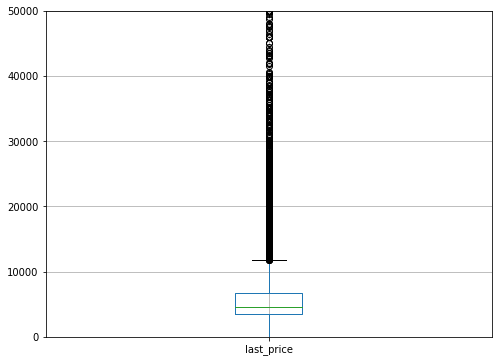

In [87]:
data.plot(y='last_price', kind='box', figsize=(8,6), grid=True)
plt.ylim(0,50000)
plt.show()

Как видно, что для квартир со стоимостью свыше 30 млн руб. черная полоса начинает разрываться и встречаются они все реже и реже.

In [88]:
#Удалим их из выборки.
data.drop(data.query('last_price > 30000').index, inplace=True)

In [89]:
data.query('last_price < 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,category_total_area,nearest_center_SPB_km
8793,7,12,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8.0,Общая площадь до 120 кв м.,9


Явно ошибка в данных - квартира площадью 109 кв.м. со стоимостью 12 тыс руб. Удалим эту строку.

In [90]:
data.drop(data.query('last_price < 100').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце total_area и их обработка.

Даже 300 кв.м. это редкость.

(50.0, 300.0)

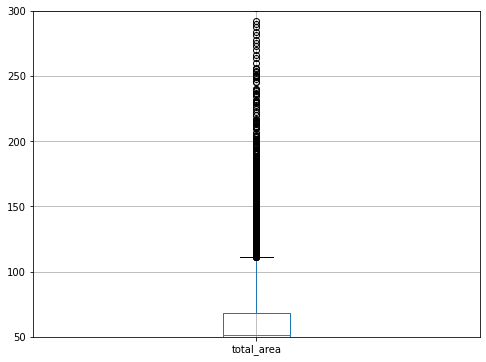

In [91]:
data.plot(y='total_area', kind='box', figsize=(8,6), grid=True)
plt.ylim(50, 300)

Как видно для квартир с общей площадью свыше 200 кв м.  черная полоса выбивающихся значений начинает рваться и данных становится меньше и меньше.

In [92]:
#Удалим их из выборки
data.drop(data.query('total_area > 200').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце rooms и их обработка.

<AxesSubplot:>

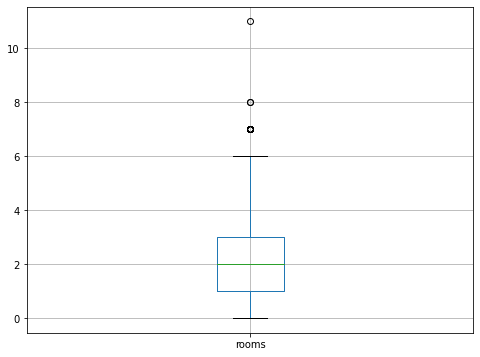

In [93]:
data.plot(y='rooms', kind='box', figsize=(8,6), grid=True)

Как-правило в элитных квартирах с большими площадями у комнат большие площади, а не много комнат с маленькой площадью, что собственно и подтверждает диаграмма размаха.
Количество комнат в 6 шт. вполне нормальное явление - свыше уже некоторая аномалия.

In [94]:
#Удалим их из выборки
data.drop(data.query('rooms > 6').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце ceiling_height и их обработка.

<AxesSubplot:>

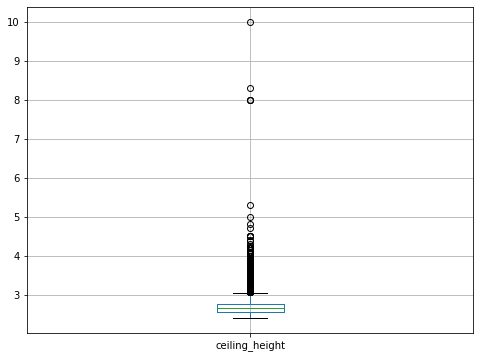

In [95]:
data.plot(y='ceiling_height', kind='box', figsize=(8,6), grid=True)

Потолки с высотой более 4 м встретиться можно не часто.

In [96]:
#Удалим их из выборки
data.drop(data.query('ceiling_height > 4').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце floors_total и их обработка.

<AxesSubplot:>

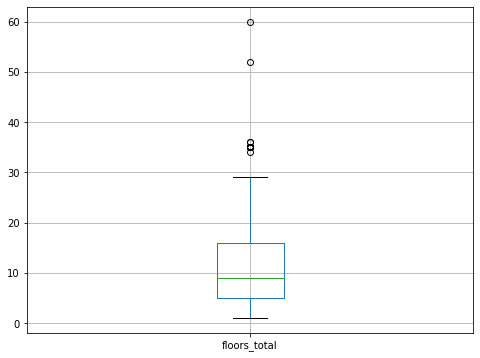

In [97]:
data.plot(y='floors_total', kind='box', figsize=(8,6), grid=True)

Здания более 30 этажей единичны и выбиваются из общей массы.

In [98]:
#Удалим их из выборки
data.drop(data.query('floors_total > 30').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце living_area и их обработка.

<AxesSubplot:>

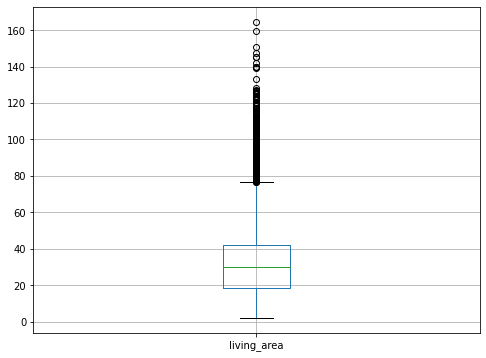

In [99]:
data.plot(y='living_area', kind='box', figsize=(8,6), grid=True)

Из диаграммы размаха видно, что квартиры с жилой площадью более 130 кв.м. довольное не частое явление.

In [100]:
#Удалим их из выборки
data.drop(data.query('living_area > 130').index, inplace=True)

Маловероятно, что жилая площадь может быть менее 6 кв.м. Посмотрим на такие данные

In [101]:
data.query('living_area < 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,category_total_area,nearest_center_SPB_km
3242,7,4440,41.0,2017-07-02,1,2.7,17,3.0,17,False,...,Санкт-Петербург,19272.0,13073.0,0,551.163107,0,NaN,216.0,Общая площадь до 50 кв м.,13
13915,20,6350,52.0,2018-02-06,2,3.0,6,2.0,2,False,...,Санкт-Петербург,32453.0,6521.0,0,386.807692,1,1012.0,91.0,Общая площадь до 60 кв м.,7
21943,15,6100,77.6,2019-02-28,4,2.5,9,5.4,1,False,...,Санкт-Петербург,29338.0,11270.0,1,584.000000,0,NaN,33.0,Общая площадь до 80 кв м.,11


Всего 3 строчки.

In [102]:
#Удалим их из выборки
data.drop(data.query('living_area < 6').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце kitchen_area и их обработка.

<AxesSubplot:>

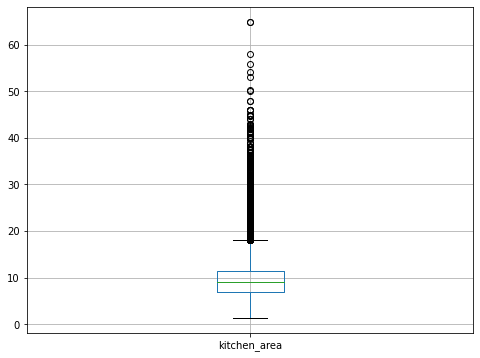

In [103]:
data.plot(y='kitchen_area', kind='box', figsize=(8,6), grid=True)

Данных с площадью более 45 кв.м. все меньше и меньше.

In [104]:
#Удалим их из выборки
data.drop(data.query('kitchen_area > 45').index, inplace=True)

Посмотрим количество строк с площадью кухни менее 3 кв.м.

In [105]:
data.query('kitchen_area < 3')['kitchen_area'].value_counts()

2.00    7
2.60    3
2.30    1
2.40    1
1.30    1
2.89    1
2.64    1
Name: kitchen_area, dtype: int64

Маловероятно, что может быть такая маленькая площадь кухни.

In [106]:
#Удалим их из выборки
data.drop(data.query('kitchen_area < 3').index, inplace=True)

##### Проверка на выбивающиеся значения в столбце days_exposition и их обработка.

<AxesSubplot:>

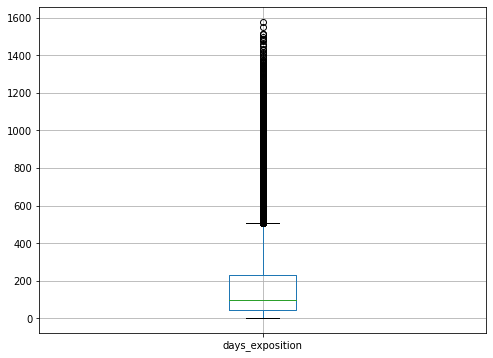

In [107]:
data.plot(y='days_exposition', kind='box', figsize=(8,6), grid=True)

Из диаграммы размаха видно, что продажи с дительность от 1400 дней становятся реже и реже. В целом этот столбец будет проанализирован позднее, на текущем этапе удалим данные с длительностью продаж свыше 1400 дней.

In [108]:
data.drop(data.query('days_exposition > 1400').index, inplace=True)

In [109]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,nearest_center_SPB_km
count,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,18138.000000,18138.000000,17485.000000,16516.000000,17485.000000,8634.000000,19886.000000,18138.000000
mean,9.818543,5652.535990,57.357536,2.021825,2.697669,10.678161,32.813867,5.883277,10.028397,0.592475,29618.836109,14664.029390,0.593366,508.025950,0.746354,523.842599,177.976315,14.662807
std,5.650193,3861.342136,24.853767,0.967859,0.210866,6.526745,16.400085,4.862919,4.413375,0.958938,13172.325623,8576.202054,0.784663,246.271607,0.919242,276.868648,214.182486,8.586800
min,0.000000,430.000000,15.000000,0.000000,2.400000,1.000000,6.000000,1.000000,3.000000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.000000
25%,6.000000,3400.000000,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,18673.750000,9860.000000,0.000000,427.000000,0.000000,303.000000,45.000000,10.000000
50%,9.000000,4600.000000,51.300000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,27635.000000,13370.000000,0.000000,489.644820,0.000000,507.000000,94.000000,13.000000
75%,14.000000,6580.000000,68.000000,3.000000,2.750000,16.000000,41.890000,8.000000,11.400000,1.000000,39065.000000,16804.000000,1.000000,557.000000,1.000000,733.000000,228.000000,17.000000
max,50.000000,30000.000000,200.000000,6.000000,4.000000,29.000000,128.000000,27.000000,45.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1396.000000,66.000000


In [110]:
print('В результате предобработки данных было удалено {:.1%}'.format(1 - data.shape[0] / old_shape_data) + ' от исходных данных')

В результате предобработки данных было удалено 3.3% от исходных данных


### Посчитайте и добавьте в таблицу новые столбцы

#### Добавление столбца со стоимость 1 кв.м. 

In [111]:
data['price_of_m2'] = (data['last_price'] / data['total_area']).astype('int')

#### Добавление столбцов с днем недели, месяцем и годом публикации объявления

In [112]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#### Добавление столбца с типом этажа квартиры

In [113]:
# Создаём функцию для заполнения нового столбца с типом этажа
def get_floor_group(value):
    if value['floor'] == 1:
        return 'первый'
    elif value['floor'] == value['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(get_floor_group, axis=1)

#### Добавление столбца с расстоянием ближайщего аэропорта и парка

In [114]:
#Столбец с растоянием до центра СПБ был добавлен ранее
data['airports_nearest_km'] = (data['airports_nearest'] / 1000).dropna().round(0).astype('Int64')
data['parks_nearest_km'] = (data['parks_nearest'] / 1000).dropna().round(0).astype('Int64')

In [115]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,days_exposition,category_total_area,nearest_center_SPB_km,price_of_m2,weekday,month,year,floor_type,airports_nearest_km,parks_nearest_km
0,20,13000,108.0,2019-03-07,3,2.700,16,51.0,8,False,...,NaN,Общая площадь до 120 кв м.,16,120,3,3,2019,другой,19,0
1,7,3350,40.4,2018-12-04,1,2.715,11,18.6,1,False,...,81.0,Общая площадь до 50 кв м.,19,82,1,12,2018,первый,13,<NA>
2,10,5196,56.0,2015-08-20,2,2.560,5,34.3,4,False,...,558.0,Общая площадь до 60 кв м.,14,92,3,8,2015,другой,22,0
4,2,10000,100.0,2018-06-19,2,3.030,14,32.0,13,False,...,121.0,Общая площадь до 100 кв м.,8,100,1,6,2018,другой,32,0
5,10,2890,30.4,2018-09-10,1,2.650,12,14.4,5,False,...,55.0,Общая площадь до 40 кв м.,<NA>,95,0,9,2018,другой,<NA>,<NA>


### Проведите исследовательский анализ данных

####  Изучение отдельных столбцов

Рассмотрим подробнее. Создадим функцию, определяющую границы "усов" для задаваемого признака.

In [116]:
# функция, получающая на вход название признака, и возвращающая границы "усов"
def get_whiskers(column):
    describe_data = data[column].describe()
    
    #межквартирльный размах
    iqr = describe_data[6] - describe_data[4]
    
    #левый и правый "ус"    
    left_whisker = round(describe_data[4] - 1.5 * iqr, 2)
    right_whisker = round(describe_data[6] + 1.5 * iqr, 2)

    
    if left_whisker < describe_data[3]: left_whisker = describe_data[3] 
        
   
    if right_whisker > describe_data[7]: right_whisker = describe_data[7]
        
    return [left_whisker, right_whisker]


In [117]:
# зададим функцию, вычисляющую долю аномальных значений
def get_persent_anomalies_data(column):
    return 'Доля выбивающихся значений из общей выборки для столбца {} составялет {:.1%}'. format(column, len(data.loc[data[column] > get_whiskers(column)[1]]) / len(data))

##### Исследование столбца last_price

Построим 2 графика - по исходным данным и график в границах усов диаграммы размаха и исследуем их.

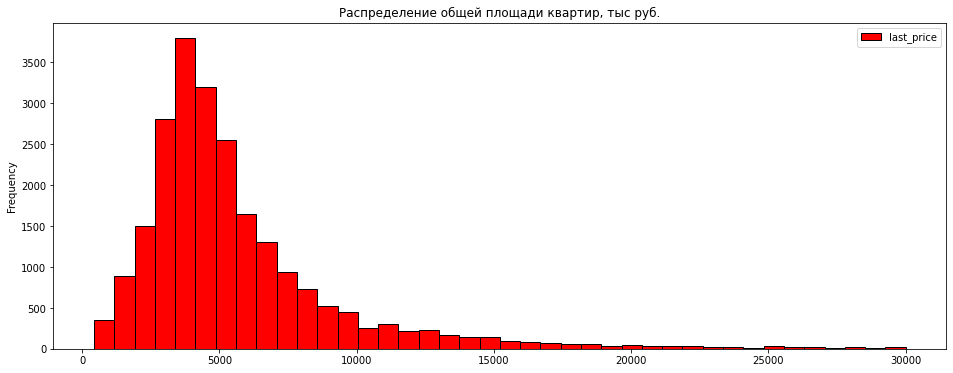

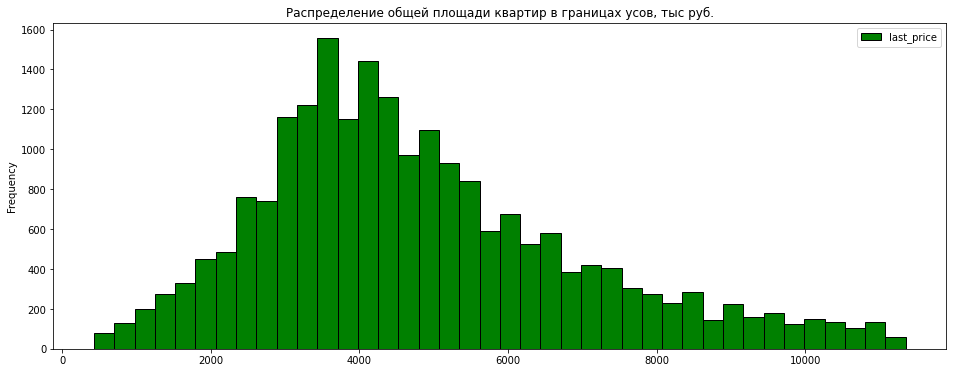

In [118]:
data.plot(
    y='last_price', 
    kind='hist', 
    bins=40, 
    figsize=(16,6), 
    ec='black', 
    color='red')
plt.title('Распределение общей площади квартир, тыс руб.')
plt.show()

data.query('last_price <= @get_whiskers("last_price")[1]').plot(
    y='last_price', 
    kind='hist', 
    bins=40, 
    figsize=(16,6), 
    ec='black', 
    color='green')
plt.title('Распределение общей площади квартир в границах усов, тыс руб.')
plt.show()

In [119]:
print(get_persent_anomalies_data('last_price'))

Доля выбивающихся значений из общей выборки для столбца last_price составялет 7.6%


Есть квартиры и за 20 млн и за 30 млн, но все-таки такие стоимости лежат за пределами «усов» диаграммы размаха, и их доля составляет порядка 7.7%. Могу предположить, что такие квартиры относятся к некоторому элитному классу жилья, который не каждый покупатель может себе позволить. На рынке чаще встречаются квартиры со стоимостью до 12 млн руб. (границы нормальных значений), при этом квартиры со стоимость 3.4 млн руб. до 4.8 млн руб. представлены чаще прочих (пик приходится на 3.8 млн руб.). Такая стоимость квартир характерна для объектов "среднего класса".

##### Исследование столбцов total_area, living_area, kitchen_area

По аналогии со столбцом со стоимость цен на квартиры построим по 2 гистограммы.

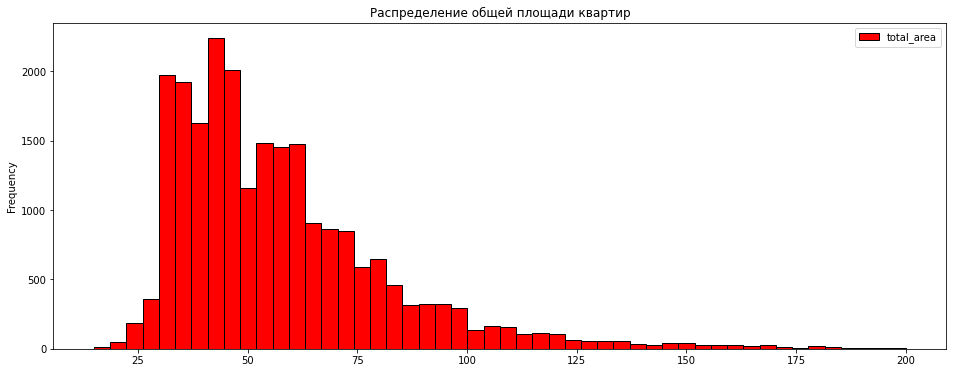

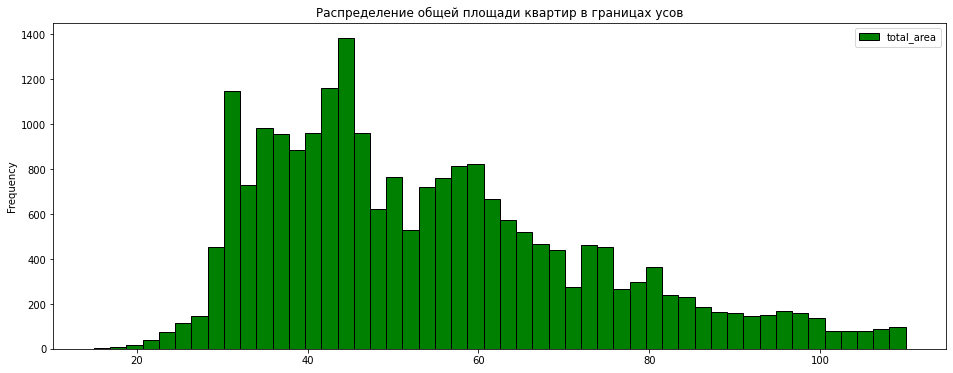

In [120]:
data.plot(y='total_area', kind='hist', bins=50, figsize=(16,6), ec='black', color='red')
plt.title('Распределение общей площади квартир')

data.query('total_area <= @get_whiskers("total_area")[1]').plot(y='total_area', kind='hist', bins=50, figsize=(16,6), ec='black', color='green')
plt.title('Распределение общей площади квартир в границах усов')

plt.show()

In [121]:
print(get_persent_anomalies_data('total_area'))

Доля выбивающихся значений из общей выборки для столбца total_area составялет 4.1%


На рынке Санкт-Петербурга и ЛО представлены квартиры с площадью до 200 кв.м., но такие квартиры характерны для жилья элитного класса и их не так уж много. В "нормальных" границах лежат квартиры с площдью от 13 кв.м. до 110 кв.м. Большая часть квартир имеет общую площадь в пределах 30-60 кв.м., при этом пик приходится на 46 кв.м. Что собственно и подтверждает общеизвестный факт, что малогабаритные квартиры пользуются наибольшим спросом.

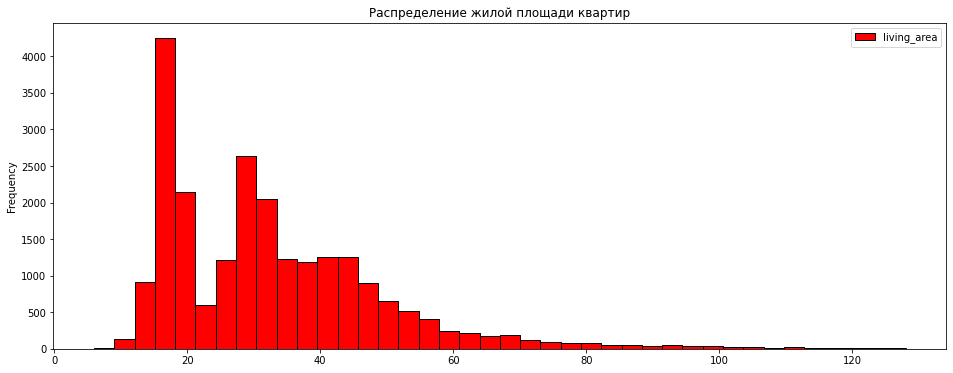

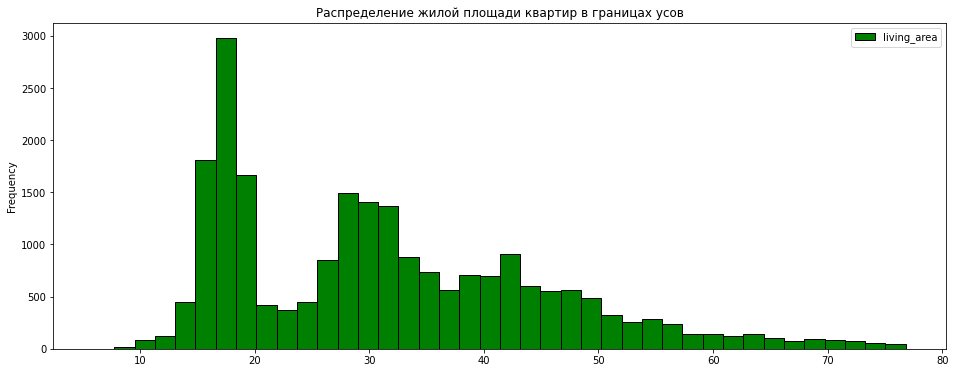

In [122]:
data.plot(y='living_area', kind='hist', bins=40, figsize=(16,6), ec='black', color='red')
plt.title('Распределение жилой площади квартир')

data.query('living_area <= @get_whiskers("living_area")[1]').plot(y='living_area', kind='hist', bins=40, figsize=(16,6), ec='black', color='green')
plt.title('Распределение жилой площади квартир в границах усов')

plt.show()


In [123]:
print(get_persent_anomalies_data('living_area'))

Доля выбивающихся значений из общей выборки для столбца living_area составялет 2.3%


Жилая площадь квартир на рынке Санкт-Петербурга и ЛО представлена предложениями до 125 кв.м., но такие квартиры опять-такие характерны для жилья элитного класса (2.4%). В "нормальных" границах лежат квартиры с жилой площдью от 8 кв.м. до 80 кв.м. Большая часть квартир имеет общую площадь в пределах 17-30 кв.м., при этом пик приходится на 18 кв.м. И снова приходим к выводу о малогабаритных квартирах.

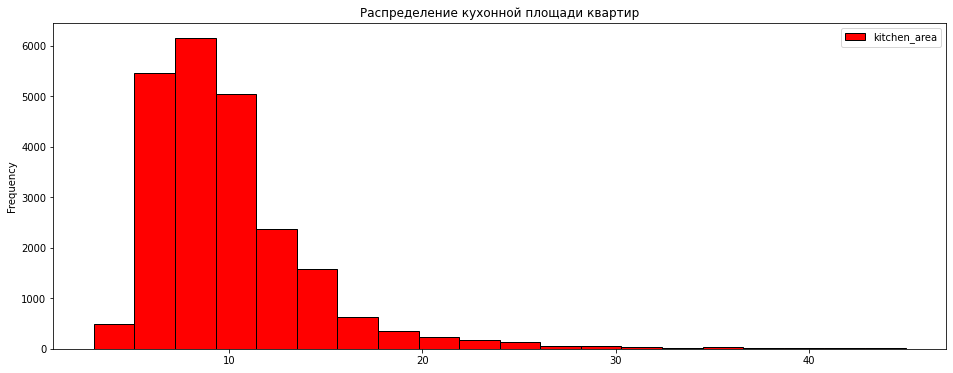

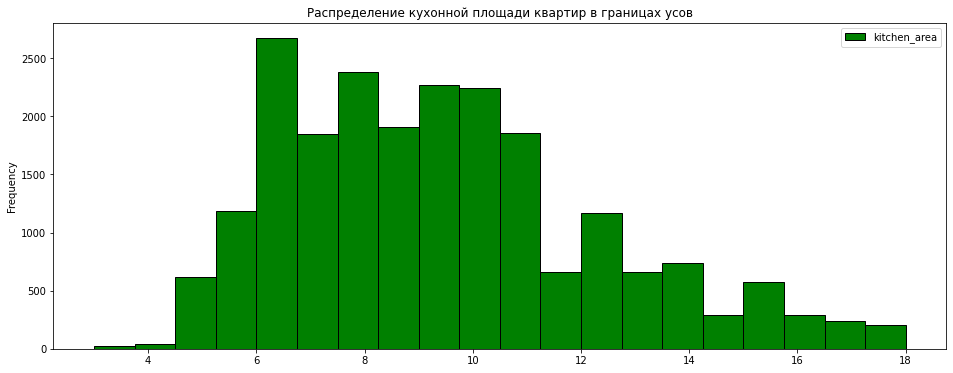

In [124]:
data.plot(y='kitchen_area', kind='hist', bins=20, figsize=(16,6), ec='black', color='red')
plt.title('Распределение кухонной площади квартир')

data.query('kitchen_area <= @get_whiskers("kitchen_area")[1]').plot(y='kitchen_area', kind='hist', bins=20, figsize=(16,6), ec='black', color='green')
plt.title('Распределение кухонной площади квартир в границах усов')

plt.show()

In [125]:
print(get_persent_anomalies_data('kitchen_area'))

Доля выбивающихся значений из общей выборки для столбца kitchen_area составялет 4.6%


Площадь кухни свыше 18 кв.м. довольно редкое явление (всего 4.7%). Наиболее часто встречающимися являются квартиры с кухонной площадью от 6 до 10 кв.м. Среднестатистическая кухня для малогабаритных квартир среднего класса.

##### Исследование столбца rooms

Данные, которые выходили за границы усов диаграммы размаха были исключены ранее. Обойдемся одной гистограммой.

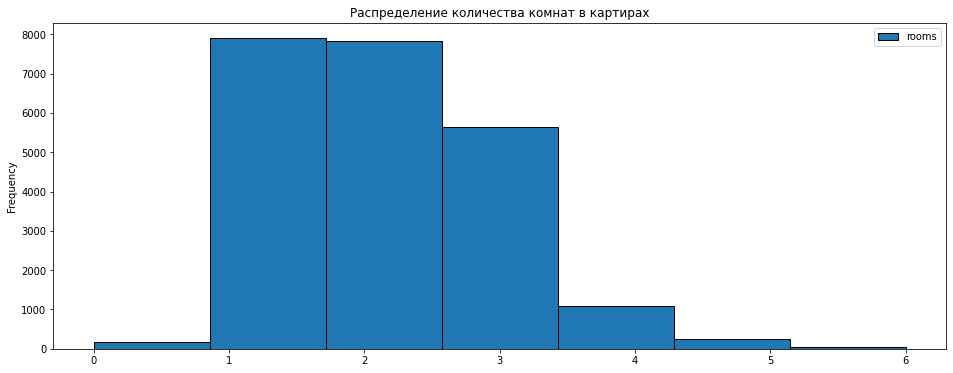

In [126]:
data.plot(y='rooms', kind='hist', bins=7, figsize=(16,6), ec='black')
plt.title('Распределение количества комнат в картирах')
plt.show()

Вывод о популярности малогабаритных квартир подтверждается - больше всего можно встретить предложения по продаже 1-2 комнатных квартир. Менее ликвидные квартиры 3 комнатные, затем уже 4 комнатные квартиры. Предложения по студиям и 5-6 комнатным квартирам довольно редкие, что собственно и подтверждает еще один общеизвестный факт о не ликвидности таких квартир.

##### Исследование столбцов ceiling_height, floor, floor_type и floors_total

Для столбцов с высотой потолков и этажом расположения квартиры построим 2 гисторгаммы - с учетом редких значений и в границах "нормальных" значений.

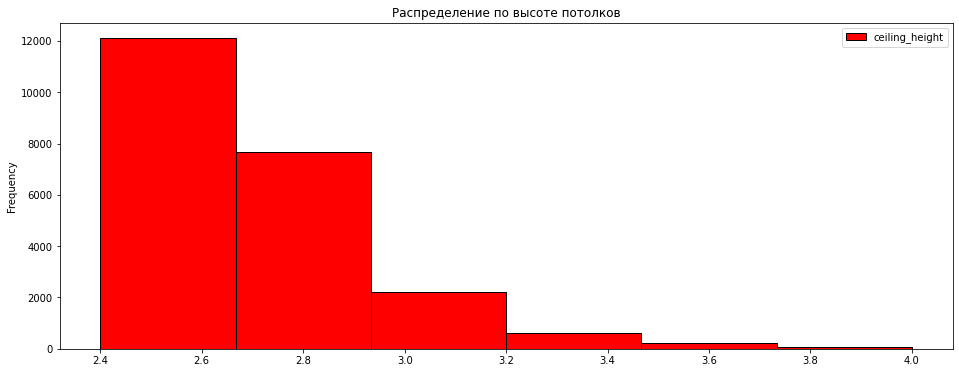

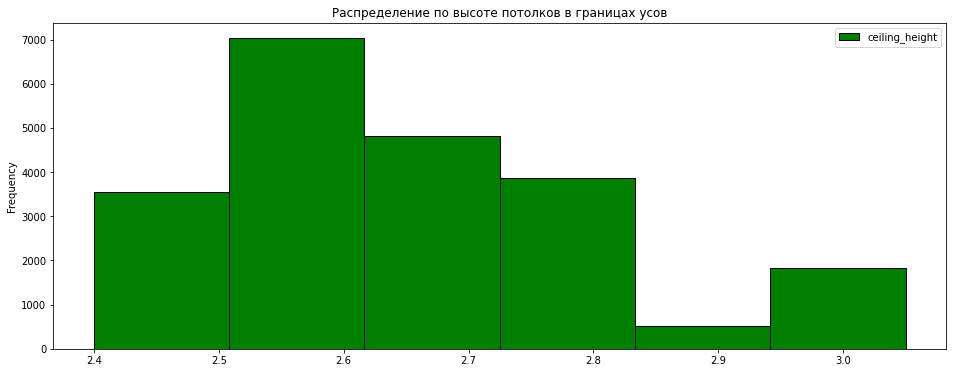

In [127]:
data.plot(y='ceiling_height', kind='hist', bins=6, figsize=(16,6), ec='black', color='red')
plt.title('Распределение по высоте потолков')

data.query('ceiling_height <= @get_whiskers("ceiling_height")[1]').plot(y='ceiling_height', kind='hist', bins=6, figsize=(16,6), ec='black', color='green')
plt.title('Распределение по высоте потолков в границах усов')

plt.show()

Все-таки высота потолков свыше 3 м. характеризует элитный класс жилья, а не средний, поэтому таких предложений на рынке не много. Наиболее распространённое предложение с высотой потолков в 2.6 м., чуть менее 2.7-2.8 м.

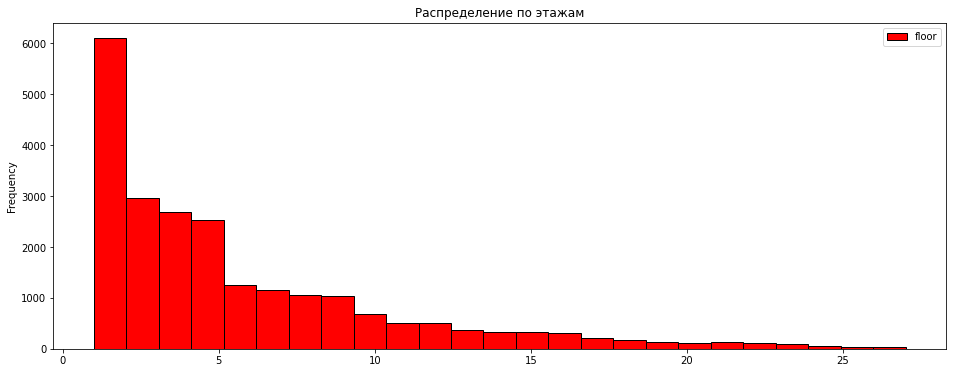

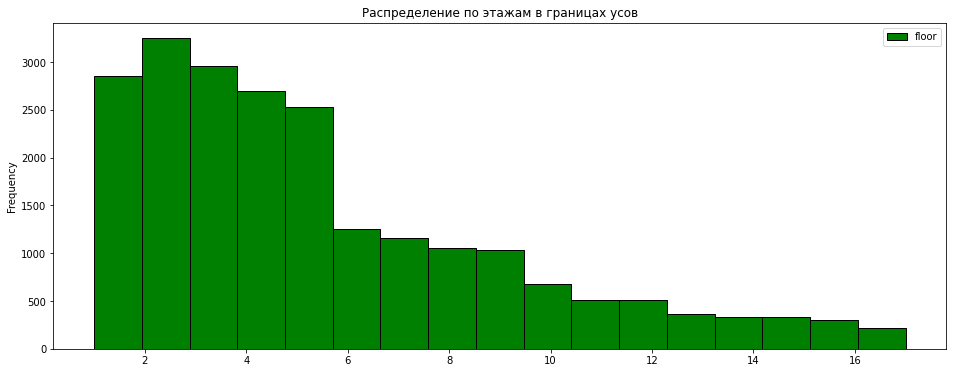

In [128]:
data.plot(y='floor', kind='hist', bins=25, figsize=(16,6), ec='black', color='red')
plt.title('Распределение по этажам')

data.query('floor <= @get_whiskers("floor")[1]').plot(y='floor', kind='hist', bins=17, figsize=(16,6), ec='black', color='green')
plt.title('Распределение по этажам в границах усов')

plt.show()

Высокоэтажные квартиры не пользуются большим спросом, наиболее чаще встречаются квартиры, которые расположены на 1-5 этажах.

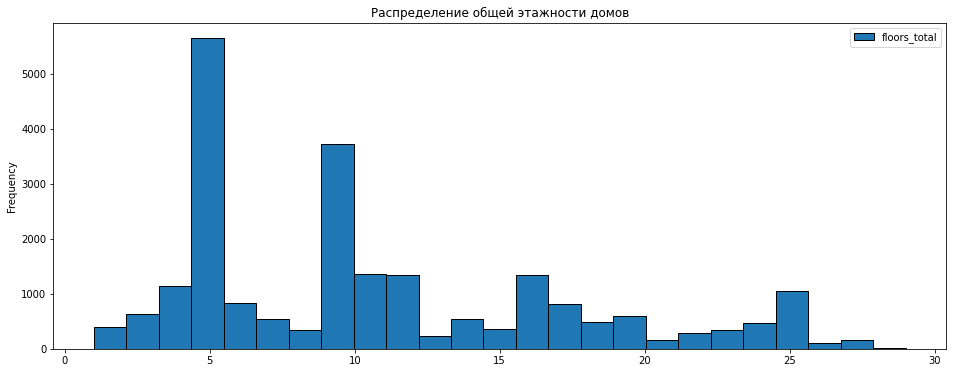

In [129]:
data.plot(y='floors_total', kind='hist', bins=25, figsize=(16,6), ec='black')
plt.title('Распределение общей этажности домов')
plt.show()

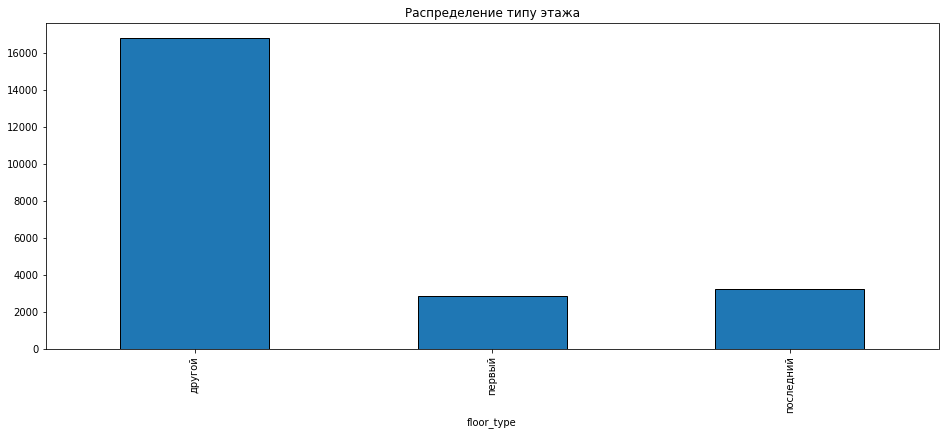

In [130]:
data.groupby('floor_type')['floor_type'].count().plot(kind='bar', figsize=(16,6), ec='black')
plt.title('Распределение типу этажа')
plt.show()

На рынке СПБ и ЛО чаще всего встречаются объявления в 5 и 9 этажных домах и при этом квартиры расположены не на первом и последниъ этажах.

##### Исследование столбца nearest_center_SPB, airports_nearest_km и parks_nearest

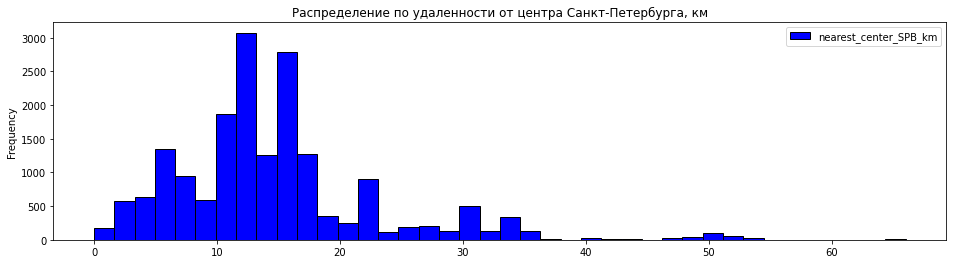

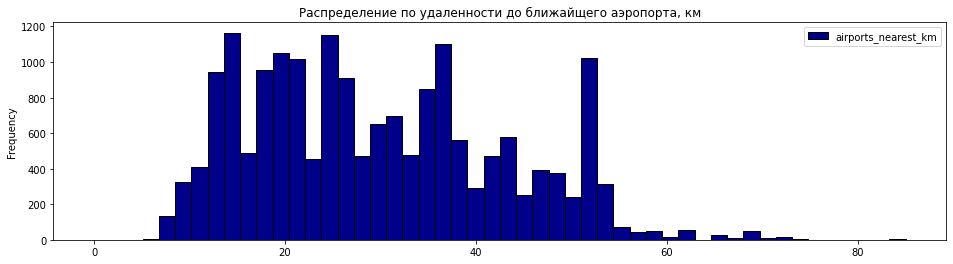

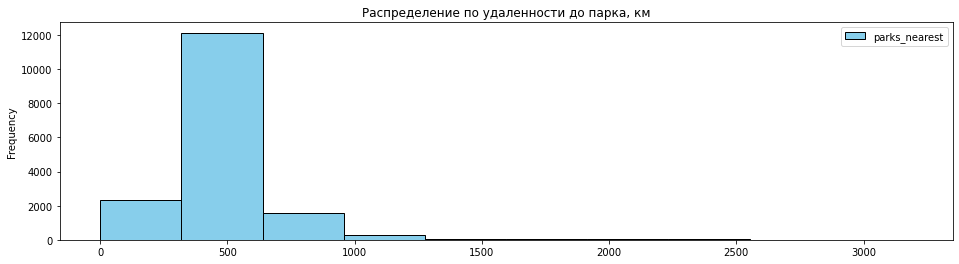

In [131]:
data.plot(
    y='nearest_center_SPB_km', 
    kind='hist', 
    bins=40, 
    figsize=(16,4), 
    ec='black',
    color = 'blue')
plt.title('Распределение по удаленности от центра Санкт-Петербурга, км')

data.plot(
    y='airports_nearest_km', 
    kind='hist', 
    bins=50, 
    figsize=(16,4), 
    ec='black',
    color= 'darkblue')
plt.title('Распределение по удаленности до ближайщего аэропорта, км')

data.plot(
    y='parks_nearest', 
    kind='hist',
    bins = 10,
    figsize=(16,4), 
    ec='black',
    color ='skyblue')
plt.title('Распределение по удаленности до парка, км')

plt.show()

Квартиры с удаленностью от центра города свыше 30 км. встречаются не часто, в основном в представленных объявлениях квартиры расположены в пределах 12-18 км. от центра города. Также по большинству объявлений расстояние до блажащего аэропорта менее 55 км. Видимо в Санкт-Петербурге и ЛО очень много парков, т.к. у большей части объявлений расстояние до ближайшего парка находится в пределах 500 м.

##### Исследование столбца weekday и month

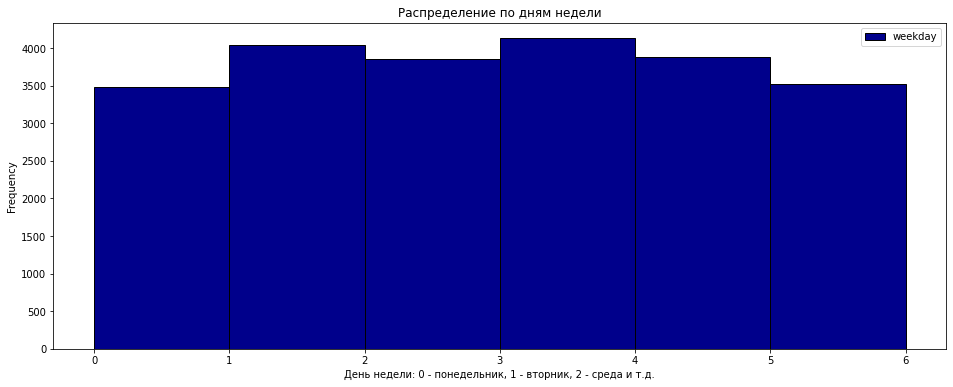

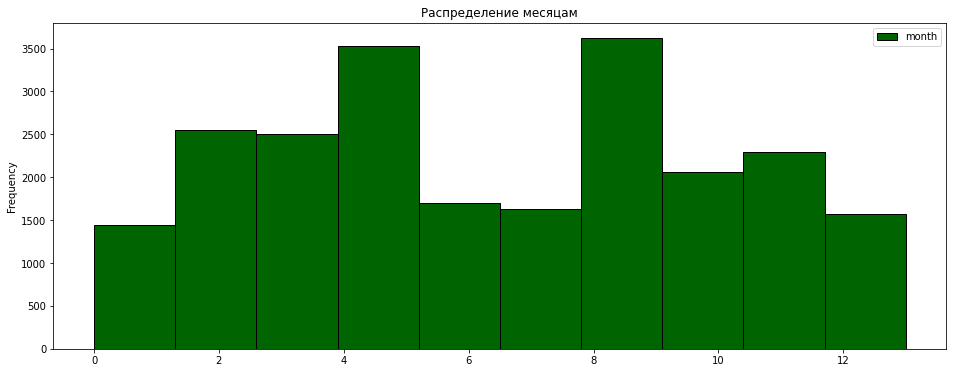

In [132]:
data.plot(
    y='weekday', 
    kind='hist', 
    bins=6, 
    figsize=(16,6), 
    ec='black', 
    color='darkblue')
plt.title('Распределение по дням недели')
plt.xlabel('День недели: 0 - понедельник, 1 - вторник, 2 - среда и т.д.')

data.query('month <= @get_whiskers("month")[1]').plot(
    y='month', 
    kind='hist', 
    range=(0,13),
    figsize=(16,6), 
    ec='black', 
    color='darkgreen')
plt.title('Распределение месяцам')
plt.show()

В целом наблюдается, что в апреле и августе публикуется больше всего объявлений, менее всего в январе, декабре (наверно вызвано новогодними праздниками и людям не до покупок или продаж квартир) и июне-июле (видимо люди больше заняты отпусками, нежели вопросами недвижимости).

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Ты корректно подбираешь основные диапазоны, а также верно читаешь графики! 
</div>

#### Изучние days_exposition

Посмотрим на данные и гистограмму по времени продажи квартир.

In [133]:
data['days_exposition'].describe()

count    19886.000000
mean       177.976315
std        214.182486
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1396.000000
Name: days_exposition, dtype: float64

Есть квартиры, которые продавались 4 года. Такой сценарий возможен для квартир большой площадью, но возможно, что это объявления, которые вовремя не были закрыты, из-за этого срок продажи не соответствует реальным и имеет очень большое значение.
Среднее время продажи чуть меньше 6 мес. (177 дней), медианное - чуть больше 3 мес (94 дня)- похоже на правду.

<AxesSubplot:>

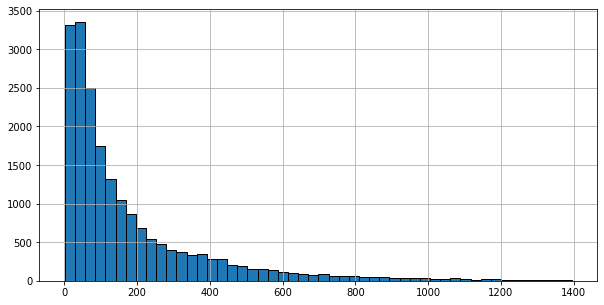

In [134]:
data['days_exposition'].hist(bins=50, figsize=(10,5), ec='black')

Большая часть квартир продавалась в течение первых 50 дней, есть и квартиры, которые продавались до года. Чем дальше, тем реже встречаются такие случаи. 

<AxesSubplot:>

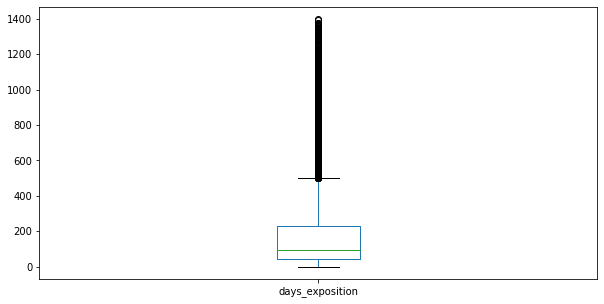

In [135]:
data.plot(y='days_exposition', kind='box', figsize = (10,5))

Как видно из диаграммы размаха выше, все что лежит за пределами правого уса - есть слишком долгие продажи. Посмотрим на границы усов.

In [136]:
print(get_persent_anomalies_data('days_exposition'))

Доля выбивающихся значений из общей выборки для столбца days_exposition составялет 7.1%


In [137]:
get_whiskers('days_exposition')

[1.0, 502.5]

Ограничим срок продажи 505 днями, чтоб убрать выбросы - 1 год и 4 месяца вполне адекватный срок для не ликвидных квартир (как-правило это крупногабаритные квартиры - в целом при анализе общей площади мы убедились, что спросом пользуются именно малогабаритные квартиры). Посмотрим на данные более детально:

<AxesSubplot:>

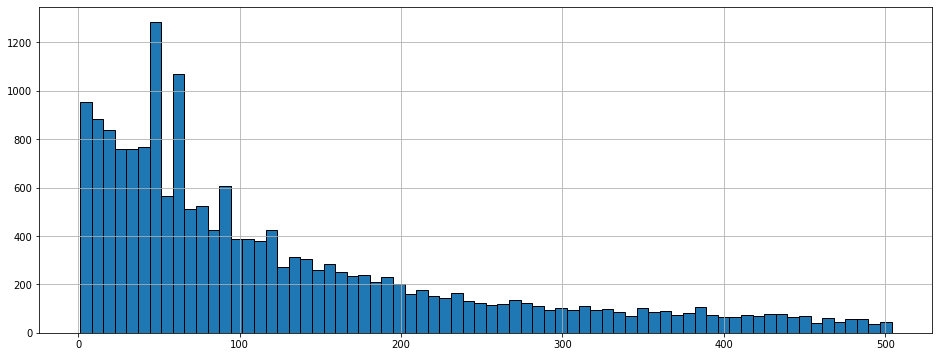

In [138]:
data.query('days_exposition < 505')['days_exposition'].hist(bins=70, figsize=(16,6), ec='black')

Отдельные пики наблюдаются в первые 3 месяца дней продаж. Посмотри более детально

<AxesSubplot:>

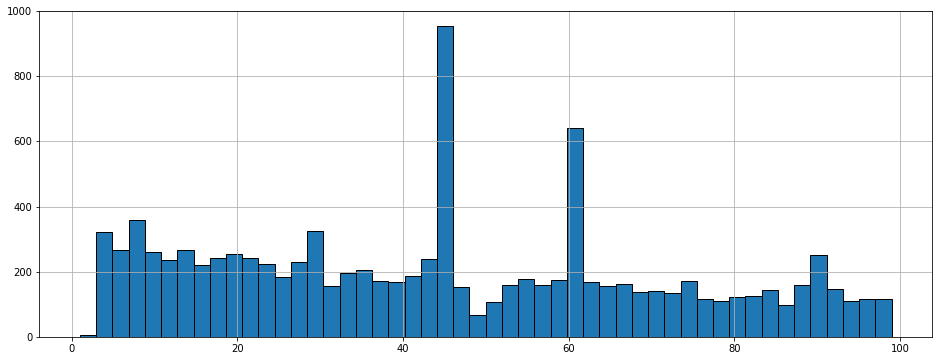

In [139]:
data.query('days_exposition < 100')['days_exposition'].hist(bins=50, figsize=(16,6), ec='black')

В целом картинка довольно гладкая, но есть два пика - 45 и 60 дней, которые явно выбиваются. В целом по правилам Яндекс.Недвижимость бесплатное объявление снимается через 45 и 60 дней, но это правило не распространяется для объявлений в Москве, Санкт-Петербурге и их областях. Необходимо сформировать баг репорт и направить 5 первых объявлений разработчикам с целью проверки не было ли каких сбоев в системе, так как эти пики выглядят довольно-таки странно.

In [140]:
bag_report_days_exposition = data.query('days_exposition == 45 or days_exposition == 60')
bag_report_days_exposition.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,days_exposition,category_total_area,nearest_center_SPB_km,price_of_m2,weekday,month,year,floor_type,airports_nearest_km,parks_nearest_km
22,20,5000,58.0,2017-04-24,2,2.75,25,30.000,15,False,...,60.0,Общая площадь до 60 кв м.,<NA>,86,0,4,2017,другой,<NA>,<NA>
82,3,4500,80.5,2018-01-15,3,2.75,25,47.495,16,False,...,60.0,Общая площадь до 90 кв м.,18,55,0,1,2018,другой,12,<NA>
105,12,4900,32.0,2018-01-07,1,2.75,25,15.000,5,False,...,60.0,Общая площадь до 40 кв м.,16,153,6,1,2018,другой,52,1
118,8,4500,31.0,2019-02-24,1,2.50,9,17.000,4,False,...,60.0,Общая площадь до 40 кв м.,9,145,6,2,2019,другой,35,1
143,9,2990,30.0,2016-06-08,1,2.50,9,20.000,9,False,...,60.0,Общая площадь до 30 кв м.,6,99,2,6,2016,последний,30,0


Исключим эти данные из дальнейщего анализа.

In [141]:
data.drop(data.query('days_exposition == 45 or days_exposition == 60').index, inplace=True)

In [142]:
print('Итого удалено {:.1%}'.format(1 - data.shape[0] / old_shape_data) + ' от исходных данных')

Итого удалено 5.6% от исходных данных


Посмотрим на данные после обработки.

In [143]:
data.query('days_exposition <= @get_whiskers("days_exposition")[1]')['days_exposition'].describe()

count    17822.000000
mean       131.062395
std        123.483815
min          1.000000
25%         40.000000
50%         89.000000
75%        188.000000
max        519.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

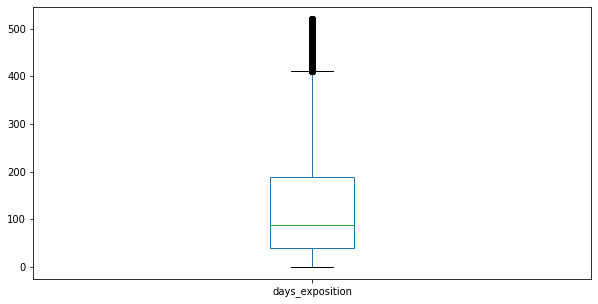

In [144]:
data.query('days_exposition <= @get_whiskers("days_exposition")[1]').plot(y='days_exposition', kind='box', figsize = (10,5))

В целом можно сделать вывод:
- среднее время продаж 140 дней, медианное время продаж 95 дней
- продажи до 37 дней есть быстрые продажи
- долгие свыше 200 дней
- "супер долгие" уже свыше 450 дней.

#### Изучение факторов, которые больше всего влияют на общую (полную) стоимость объекта

##### Проверим зависимость между общей площадью и стоимостью продажи. 
Предполагаю, что зависимость будет довольно сильной, как-правило - чем больше площадь, тем выше стоимость

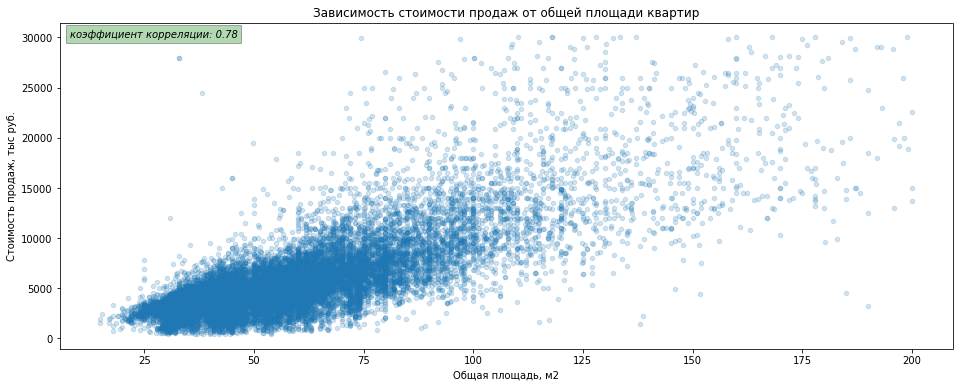

In [145]:
data.plot(x='total_area', y ='last_price', kind='scatter', alpha=0.2, figsize=(16,6))
plt.text(8, 30000,
         'коэффициент корреляции: ' + str(round(data['last_price'].corr(data['total_area']), 2)), 
         style='italic',
         bbox={'facecolor': 'green', 'alpha':0.3})
plt.xlabel('Общая площадь, м2')
plt.ylabel('Стоимость продаж, тыс руб.')
plt.title('Зависимость стоимости продаж от общей площади квартир')
plt.show()

Высокая зависимость прослеживается для квартир с общей площадью до 100 кв.м., далее большой разброс значений. Значение к-та корреляции подтверждает высокую зависимость между стоимость продажи и общей площадью.

##### Проверим зависимости между стоимость продаж, жилой и кухонной площадью.

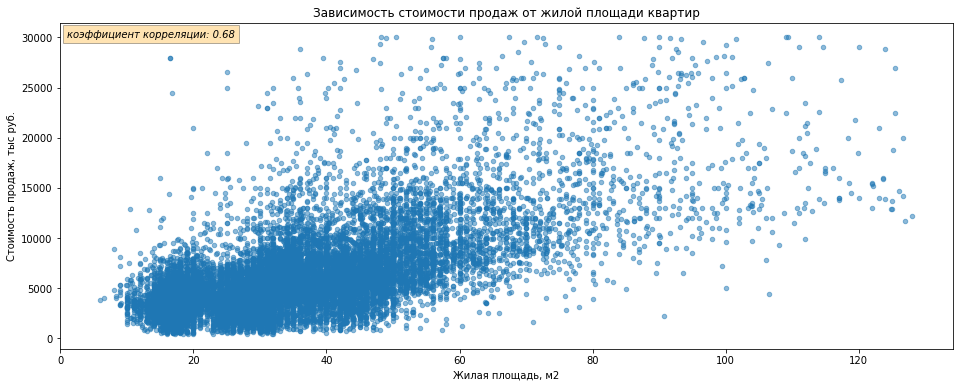

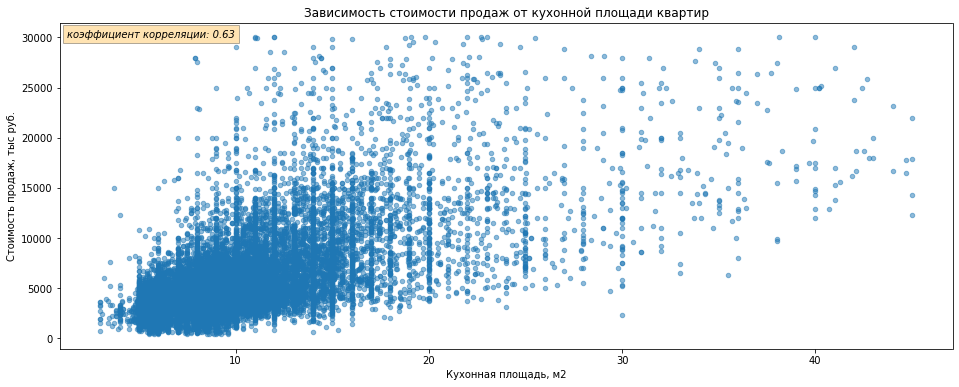

In [146]:
data.plot(x='living_area', y ='last_price', kind='scatter', alpha=0.5, figsize=(16,6))
plt.text(1, 30000,
         'коэффициент корреляции: ' + str(round(data['living_area'].corr(data['last_price']), 2)), 
         style='italic',
         bbox={'facecolor': 'orange', 'alpha':0.3})
plt.xlabel('Жилая площадь, м2')
plt.ylabel('Стоимость продаж, тыс руб.')
plt.title('Зависимость стоимости продаж от жилой площади квартир')

data.plot(x='kitchen_area', y ='last_price', kind='scatter', alpha=0.5, figsize=(16,6))
plt.text(1.3, 30000,
         'коэффициент корреляции: ' + str(round(data['kitchen_area'].corr(data['last_price']), 2)), 
         style='italic',
         bbox={'facecolor': 'orange', 'alpha':0.3})
plt.xlabel('Кухонная площадь, м2')
plt.ylabel('Стоимость продаж, тыс руб.')
plt.title('Зависимость стоимости продаж от кухонной площади квартир')

plt.show()

Ожидаемо, что зависимость между стоимостью продаж и жилой/кухонной плоащдью будет ниже, чем между стоимостью продаж и общей площадью, но все же значение к-та корреляции на уровне 0.64-0.67 показывает умеренную зависимость между показателями.

##### Проверим зависимость между стоимость продаж и количеством комнат

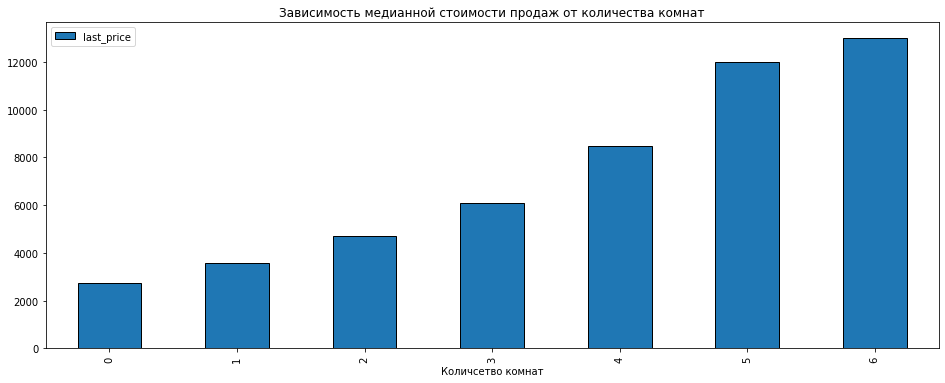

In [147]:
data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(
    kind='bar', 
    figsize=(16,6), 
    ec='black')
plt.xlabel('Количсетво комнат')
plt.title('Зависимость медианной стоимости продаж от количества комнат')
plt.show()

Все как и ожидалось. Наблюдаем линейную зависимость - стоимость квартир возрастает по мере увеличения количества комнат.

##### Проверим зависимость между стоимость продаж и типом этажа

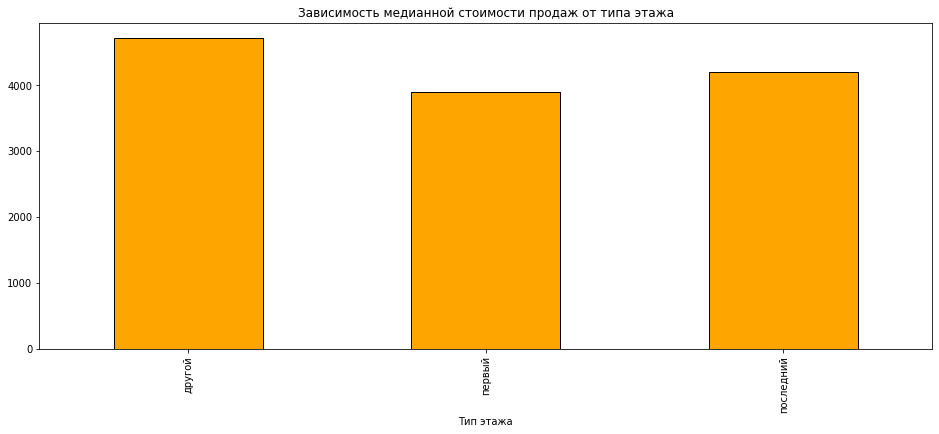

In [148]:
data.groupby('floor_type')['last_price'].median().plot(kind='bar', figsize=(16,6), ec='black', color='orange')
plt.xlabel('Тип этажа')
plt.title('Зависимость медианной стоимости продаж от типа этажа')
plt.show()

Цены на квартиры на 1-ом этаже ниже, чем цены на квартиры, расположенные на других и последнем этажах. Дороже всего квартиры на этажах отличных от 1-го и последнего.

##### Теперь исследуем зависимость цены от дня недели, месяца и года.

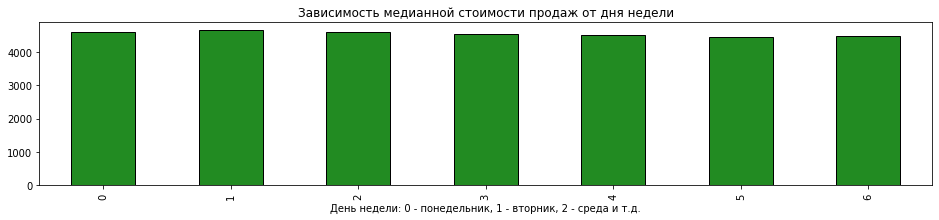

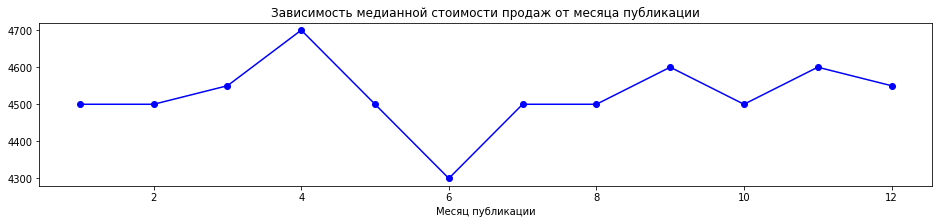

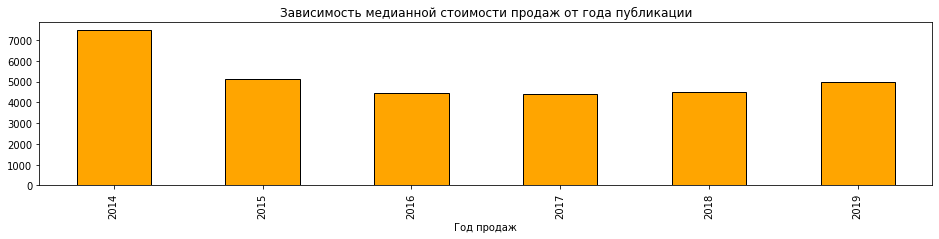

In [149]:
data.groupby('weekday')['last_price'].median().plot(kind='bar', figsize=(16,3), ec='black', color='forestgreen')
plt.xlabel('День недели: 0 - понедельник, 1 - вторник, 2 - среда и т.д.')
plt.title('Зависимость медианной стоимости продаж от дня недели')
plt.show()

data.groupby('month')['last_price'].median().plot(figsize=(16,3), color='blue',  marker='o')
plt.xlabel('Месяц публикации')
plt.title('Зависимость медианной стоимости продаж от месяца публикации')
plt.show()

data.groupby('year')['last_price'].median().plot(kind='bar', figsize=(16,3), ec='black', color='orange')
plt.xlabel('Год продаж')
plt.title('Зависимость медианной стоимости продаж от года публикации')
plt.show()

Наблюдаем следующее:
- зависимость цены от дня недели публикации никак не зависит.
- зависимость цены от месяца публикации - апрель оказался самым "дорогим": цены на квартиры, чьи объявления о продаже были опубликованы в апреле, выше, чем по остальным месяцам. По июньским объявлениям видим падение стоимости.
- выделяется 2014г. Рассмотрим его на уровень ниже (по месяцам) и тогда сделаем вывод про зависимость цены от года публикации.

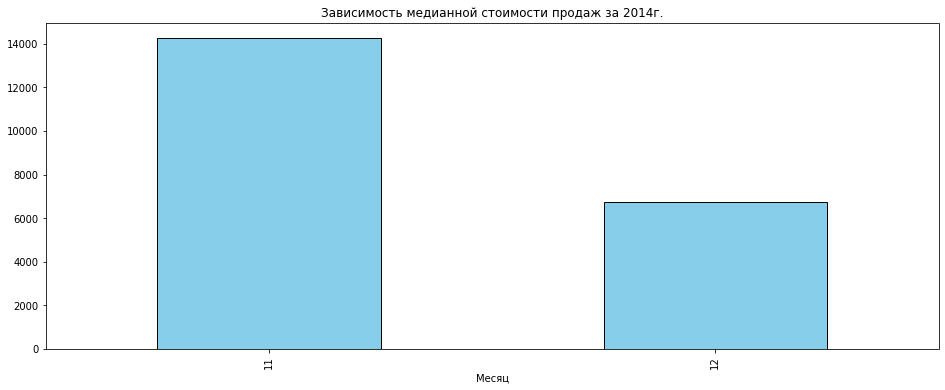

In [150]:
data.query('year == 2014').groupby('month')['last_price'].median().plot(kind='bar', figsize=(16,6), ec='black', color='skyblue')
plt.xlabel('Месяц')
plt.title('Зависимость медианной стоимости продаж за 2014г.')
plt.show()

Возможно, что такие высокие цены были связаны со "взрывом" на рынке недвижимости,который был в 2014г., вызванным резким падением рубля.
В 2019г. цена стала опять расти, что связано с тем, что после 5 лет застоя рынок недвижимости пришел в себя, а как известно повышение спроса сопровождается увеличением цен.

#### Сравнение самой высокой и самой низкой стоимости 1 кв.м. в ТОП-10 населенных пунктах по количеству объявлений

In [151]:
#Определим топ 10 населенных пунктов по количеству объявлений
top_city_list = data['locality_name'].value_counts().head(10)
top_city_list

Санкт-Петербург    14691
Мурино               561
Кудрово              446
Шушары               425
Всеволожск           385
Пушкин               353
Колпино              329
Парголово            304
Гатчина              296
Выборг               230
Name: locality_name, dtype: int64

In [152]:
#Создадим сводную таблицу по топ-10 населенным пунктам с общей суммой продаж и их количеством
top_data_total_price = (data
        .query('locality_name in @top_city_list.index')
        .pivot_table(index='locality_name', values='last_price', aggfunc=['sum', 'count'])
       )
top_data_total_price.columns = ['sum', 'count']
#Добавляем столбец с расчетом средней стоимости продаж
top_data_total_price['mean_total_price'] = (top_data_total_price['sum'] / top_data_total_price['count']).round(0)

In [153]:
#По аналогии создадим таблицу с общей площадью
top_data_total_area = (data
        .query('locality_name in @top_city_list.index')
        .pivot_table(index='locality_name', values='total_area', aggfunc='sum')
       )

In [154]:
#Объеденим две таблицы
final_top_data = top_data_total_price.join(top_data_total_area)
#Расчет срденей стоимости 1 кв.м.
final_top_data['mean_price'] = (final_top_data['sum'] / final_top_data['total_area']).round(2)
#Удалим лишнии столбцы
final_top_data.drop(columns = ['sum','count','total_area'], inplace=True)
#Переименование столбцов
final_top_data.columns = ['Средняя стоимость квартиры, тыс руб.', 'Средняя стоимость 1 кв.м., тыс руб.']
final_top_data.index.rename('Населенный пункт', inplace=True)
final_top_data = final_top_data.sort_values(by='Средняя стоимость 1 кв.м., тыс руб.', ascending=False)

In [155]:
final_top_data

,"Средняя стоимость квартиры, тыс руб.","Средняя стоимость 1 кв.м., тыс руб."
Населенный пункт,,
Санкт-Петербург,6782.0,112.08
Пушкин,6160.0,105.17
Кудрово,4339.0,93.88
Парголово,4434.0,87.48
Мурино,3689.0,83.13
Шушары,4091.0,76.29
Колпино,3850.0,73.95
Гатчина,3439.0,68.23
Всеволожск,3775.0,67.41


Как и ожидалось, самые дорогие квартиры в Санкт-Петербурге. Чем дальше от города, тем дешевле. В Выборге средняя цена за квадратный метр почти в 2 раз ниже, чем в Санкт-Петербурге.

#### Определение стоимости каждого км в Санкт-Петербурге по удаленности от центра города

In [156]:
data_spb = data.query('locality_name == "Санкт-Петербург"')

In [157]:
data_spb_final = data_spb.pivot_table(index='nearest_center_SPB_km', values='last_price', aggfunc='mean')
data_spb_final['last_price'] = data_spb_final['last_price'].round(0)
data_spb_final.columns =['Средняя стоимость, тыс руб.']
data_spb_final.index.rename('Удаленность от центра, км', inplace=True)

In [158]:
data_spb_final

,"Средняя стоимость, тыс руб."
"Удаленность от центра, км",
0,11565.0
1,11778.0
2,10729.0
3,9645.0
4,10197.0
5,10647.0
6,9532.0
7,9342.0
8,8777.0


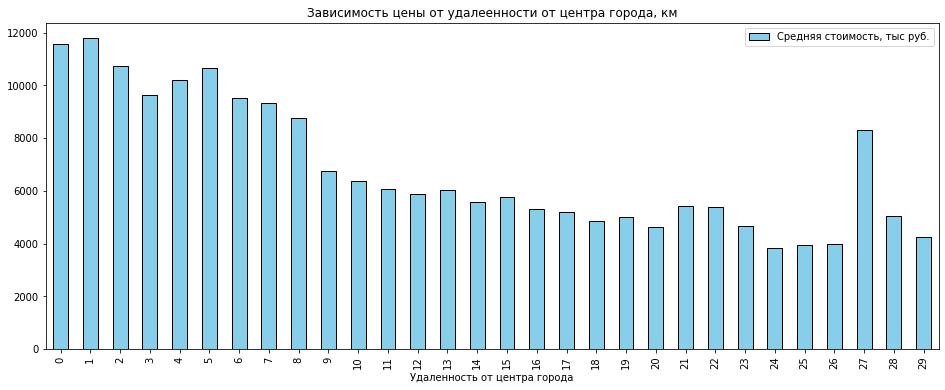

In [159]:
data_spb_final.plot(kind='bar', figsize=(16,6), ec='black', color='skyblue')
plt.title('Зависимость цены от удалеенности от центра города, км')
plt.xlabel('Удаленность от центра города')
plt.show()

Ожидаемо, что в центре (в пределах 1 км) средняя цена на квартиру стремится к максимуму. На 9 км. стоимость заметно падает (снижение около 10% относительно удаленности в 8 км.), можно предположить, что центр ограничен радиусом в 8 км (стоимость квартир от 10 млн руб.). Однако, по какой-то причине стоимость проседает на 3 км и растет на 4 и 5 км не совсем понятно почему. 
На графике также выделяется стоимость квартир с удаленностью 27 км., видимо это некий элитный район города, возможно, с природными парками, чистым воздухом и т.д. - отсюда и высокая цена (относительно удаленности от 9 до 26 км).

### Общий вывод

В целом можно сделать вывод, что на рынке Санкт-Петербурга и ЛО наибольшее количество объявлений малогабаритных квартир.

**При исследовании срока продажи квартиры были сделаны следующие наблюдения**
- есть два пика - 45 и 60 дней, которые явно выбиваются. В целом по правилам Яндекс.Недвижимость бесплатное объявление снимается через 45 и 60 дней, но это правило не распространяется для объявлений в Москве, Санкт-Петербурге и их областях. Необходимо проверить корректность работы системы на отдельных объявлениях по сформированному багрепорту.
- медианный срок продажи квартиры составляет 95 дней, что вполне адекватно. 
- продажи менее 37 дней можно считать быстрыми, продажи свыше 200 дней можно считать долгими.
- есть продажи со сроком свыше 450 дней, но это уже отдельная категория -"супердолгие", возможно объявления по таким продажам продавцы просто не сняли с сервиса.

**При исследовании факторов, влияющих на стоимость объекта, были сделаны следующие наблюдения**
- Чем больше общая площадь квартиры, тем выше ее стоимость
- Чем выше доля жилой/ кухонной площади, тем выше стоимость квартиры, но все-таки стоимость квартир в большей степени зависит от общей площади, нежели чем от жилой или кухонной площади
- Чем больше комнат, тем выше стоимость квартиры
- Цены на квартиры на 1-ом этаже ниже, чем цены на квартиры, расположенные на других и последнем этажах. Дороже всего квартиры на этажах отличных от 1-го и последнего.
- День публикации объявления практически не влияет на ее стоимость
- Квартиры, размещенные к продаже в летние месяцы и в октябре, в среднем дешевле, чем размещенные в любые другие месяца. В начале и в конце года цены стабильные и высокие. Пик наблюдается в апреле.
- Квартиры, которые были размещены в 2014г. имеют наибольшую стоимость, возможно, что такие высокие цены были связаны со "взрывом" на рынке недвижимости, который был в 2014г., вызванным резким падением рубля. В 2019г. цена стала опять расти, что связано с тем, что после 5 лет застоя рынок недвижимости пришел в себя.

Также важное наблюдение, что чем ближе квартира расположена к центру Санкт-Петербурга, тем выше ее стоимость. В пределах 1 км до центра квартиры стоят на порядок дороже, чем на более удаленных. При этом, как и ожидалось, самые дорогие квартиры в Санкт-Петербурге.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод